# Dataset

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1rWs5F3UO9h1BDnFSFDhLJmDC3F0BvhSM"
output = "dataset.zip"  # change name if needed

gdown.download(url, output, quiet=False)

!unzip dataset.zip

Downloading...
From (original): https://drive.google.com/uc?id=1rWs5F3UO9h1BDnFSFDhLJmDC3F0BvhSM
From (redirected): https://drive.google.com/uc?id=1rWs5F3UO9h1BDnFSFDhLJmDC3F0BvhSM&confirm=t&uuid=eadb516c-03ce-4d79-8d3b-bcf7c6e7cf21
To: /content/dataset.zip
100%|██████████| 1.81G/1.81G [00:10<00:00, 177MB/s]


Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [ ]:
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Path to your dataset root
DATASET_ROOT = Path("Dataset")

BATCH_SIZE = 32
NUM_WORKERS = 0
PIN_MEMORY = False
IMAGE_SIZE = 256

In [ ]:
# Data augmentation + normalization for training
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

# Only normalization for validation & test
eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

In [ ]:
train_dataset = datasets.ImageFolder(
    root=DATASET_ROOT / "Train",
    transform=train_transform,
)

val_dataset = datasets.ImageFolder(
    root=DATASET_ROOT / "Validation",
    transform=eval_transform,
)

test_dataset = datasets.ImageFolder(
    root=DATASET_ROOT / "Test",
    transform=eval_transform,
)

# Class names and label mapping
class_names = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

print("Classes:", class_names)
print("Class to index:", class_to_idx)

print("Train size:", len(train_dataset))
print("Val size:", len(val_dataset))
print("Test size:", len(test_dataset))


Classes: ['Fake', 'Real']
Class to index: {'Fake': 0, 'Real': 1}
Train size: 140002
Val size: 39428
Test size: 10905


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)
print("Batch label tensor shape:", labels.shape)

Batch image tensor shape: torch.Size([32, 3, 256, 256])
Batch label tensor shape: torch.Size([32])


# Training

In [ ]:
from __future__ import annotations

import copy
from typing import Any, Dict, Iterable, List, Optional, Type, Union

import torch
from torch import nn
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm  # <-- added


def train_model(
    model: nn.Module,
    train_dataset: Dataset,
    eval_dataset: Dataset,
    *,
    num_epochs: int,
    base_lr: float,
    optimizer_cls: Type[Optimizer] = torch.optim.Adam,
    optimizer_kwargs: Optional[Dict[str, Any]] = None,
    optimizer_params: Optional[Iterable[Union[nn.Parameter, Dict[str, Any]]]] = None,
    lr_scheduler_cls: Optional[Type[_LRScheduler]] = None,
    lr_scheduler_kwargs: Optional[Dict[str, Any]] = None,
    scheduler_step_per_batch: bool = False,
    batch_size: int = 32,
    num_workers: int = 0,
    pin_memory: bool = False,
    device: Optional[Union[str, torch.device]] = None,
    criterion: Optional[nn.Module] = None,
    use_amp: bool = True,
    grad_clip_norm: Optional[float] = None,
    non_blocking: bool = True,
    verbose: bool = True,
) -> Dict[str, List[float]]:
    """
    Train and evaluate a model on a classification task.

    Args:
        model: The nn.Module to train.
        train_dataset: Dataset used for training.
        eval_dataset: Dataset used for evaluation (validation OR test).
        num_epochs: Number of full passes over the training dataset.
        base_lr: Base learning rate. Used as optimizer `lr` unless overridden
                 via `optimizer_kwargs`.
        optimizer_cls: Optimizer class (e.g. torch.optim.Adam, SGD, AdamW).
        optimizer_kwargs: Extra kwargs passed to the optimizer constructor.
        optimizer_params: Iterable of parameters or param groups. If None,
                          `model.parameters()` is used.
        lr_scheduler_cls: LR scheduler class (e.g. StepLR, CosineAnnealingLR).
        lr_scheduler_kwargs: Extra kwargs for the scheduler.
        scheduler_step_per_batch: If True, call `scheduler.step()` every batch.
                                  If False, call it once per epoch.
        batch_size: Batch size for both train and eval loaders.
        num_workers: DataLoader workers.
        pin_memory: DataLoader pin_memory flag.
        device: Device string or torch.device. If None, auto-selects CUDA if available.
        criterion: Loss function. Defaults to nn.CrossEntropyLoss().
        use_amp: If True and CUDA is available, use mixed-precision training.
        grad_clip_norm: If not None, apply gradient clipping with this max norm.
        non_blocking: If True, use non_blocking transfers to device.
        verbose: If True, print epoch-level metrics.

    Returns:
        A dict with per-epoch metrics:
            {
                "train_loss": [...],
                "train_acc":  [...],
                "eval_loss":  [...],
                "eval_acc":   [...],
            }
        where "eval_*" corresponds to whatever you passed as `eval_dataset`
        (validation, test, etc.).
    """
    # ---- device & loss ----
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    model.to(device)

    if criterion is None:
        criterion = nn.CrossEntropyLoss()

    # ---- dataloaders ----
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    eval_loader = DataLoader(
        eval_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    # ---- optimizer ----
    if optimizer_kwargs is None:
        optimizer_kwargs = {}

    # Respect explicit lr if user put it in optimizer_kwargs; otherwise use base_lr
    optimizer_kwargs.setdefault("lr", base_lr)

    if optimizer_params is None:
        optimizer_params = model.parameters()

    optimizer = optimizer_cls(optimizer_params, **optimizer_kwargs)

    # ---- scheduler (optional) ----
    scheduler: Optional[_LRScheduler] = None
    if lr_scheduler_cls is not None:
        if lr_scheduler_kwargs is None:
            lr_scheduler_kwargs = {}
        scheduler = lr_scheduler_cls(optimizer, **lr_scheduler_kwargs)

    # ---- AMP scaler ----
    use_amp = bool(use_amp and device.type == "cuda")
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    history: Dict[str, List[float]] = {
        "train_loss": [],
        "train_acc": [],
        "eval_loss": [],
        "eval_acc": [],
    }

    # outer progress bar over epochs
    epoch_iter = range(1, num_epochs + 1)
    if verbose:
        epoch_iter = tqdm(epoch_iter, desc="Epochs")

    best_eval_loss = float("inf")
    best_state_dict = copy.deepcopy(model.state_dict())

    for epoch in epoch_iter:
        # ========================= TRAIN =========================
        model.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        # inner progress bar over training batches
        train_batch_iter = train_loader
        if verbose:
            train_batch_iter = tqdm(
                train_loader,
                desc=f"Train {epoch}/{num_epochs}",
                leave=False,
            )

        for inputs, targets in train_batch_iter:
            inputs = inputs.to(device, non_blocking=non_blocking)
            targets = targets.to(device, non_blocking=non_blocking)

            optimizer.zero_grad(set_to_none=True)

            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                scaler.scale(loss).backward()

                if grad_clip_norm is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)

                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()

                if grad_clip_norm is not None:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_norm)

                optimizer.step()

            batch_size_curr = inputs.size(0)
            train_loss_sum += loss.item() * batch_size_curr
            preds = outputs.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += batch_size_curr

            if scheduler is not None and scheduler_step_per_batch:
                scheduler.step()

        epoch_train_loss = train_loss_sum / train_total
        epoch_train_acc = train_correct / train_total

        # ========================= EVAL =========================
        model.eval()
        eval_loss_sum = 0.0
        eval_correct = 0
        eval_total = 0

        # inner progress bar over eval batches
        eval_batch_iter = eval_loader
        if verbose:
            eval_batch_iter = tqdm(
                eval_loader,
                desc=f"Eval {epoch}/{num_epochs}",
                leave=False,
            )

        with torch.no_grad():
            for inputs, targets in eval_batch_iter:
                inputs = inputs.to(device, non_blocking=non_blocking)
                targets = targets.to(device, non_blocking=non_blocking)

                if use_amp:
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, targets)
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                batch_size_curr = inputs.size(0)
                eval_loss_sum += loss.item() * batch_size_curr
                preds = outputs.argmax(dim=1)
                eval_correct += (preds == targets).sum().item()
                eval_total += batch_size_curr

        epoch_eval_loss = eval_loss_sum / eval_total
        epoch_eval_acc = eval_correct / eval_total

        if scheduler is not None and not scheduler_step_per_batch:
            scheduler.step()

        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)
        history["eval_loss"].append(epoch_eval_loss)
        history["eval_acc"].append(epoch_eval_acc)

        if epoch_eval_loss < best_eval_loss:
            best_eval_loss = epoch_eval_loss
            best_state_dict = copy.deepcopy(model.state_dict())

        if verbose:
            print(
                f"Epoch {epoch:03d}/{num_epochs:03d} "
                f"- train_loss: {epoch_train_loss:.4f}, train_acc: {epoch_train_acc:.4f} "
                f"- eval_loss: {epoch_eval_loss:.4f}, eval_acc: {epoch_eval_acc:.4f}"
            )

    model.load_state_dict(best_state_dict)

    return history


In [ ]:
from __future__ import annotations

from typing import Any, Callable, Dict, Iterable, List

from itertools import product

import torch
from torch import nn
from torch.utils.data import Dataset


def grid_combinations(
    static: Dict[str, Any],
    grid: Dict[str, Iterable[Any]],
) -> List[Dict[str, Any]]:
    """
    Create list of config dicts by combining static values with a simple
    Cartesian product over the grid dict.

    - `static`: fixed parameters (same for all runs).
    - `grid`:   each key has a list/iterable of values to sweep over.

    Grid values override same-named static values.
    """
    if not grid:
        return [dict(static)]

    keys = list(grid.keys())
    values_lists = [list(grid[k]) for k in keys]

    combos: List[Dict[str, Any]] = []
    for values in product(*values_lists):
        cfg = dict(static)
        cfg.update(zip(keys, values))  # grid overrides static
        combos.append(cfg)
    return combos


def run_ablation(
    build_model: Callable[..., nn.Module],
    train_model_fn: Callable[..., Dict[str, List[float]]],
    train_dataset: Dataset,
    eval_dataset: Dataset,
    *,
    model_static: Dict[str, Any],
    model_grid: Dict[str, Iterable[Any]],
    train_static: Dict[str, Any],
    train_grid: Dict[str, Iterable[Any]],
    num_epochs: int = 20,
    verbose: bool = True,
) -> Dict[str, Any]:
    """
    Exhaustive ablation over model + training hyperparameter grids.

    Args:
        build_model:
            Callable that instantiates the model.
            It will be called as: `build_model(**model_kwargs)`.

        train_model_fn:
            Your training loop function (the one we defined earlier),
            called as:
                train_model_fn(
                    model=model,
                    train_dataset=train_dataset,
                    eval_dataset=eval_dataset,
                    num_epochs=epochs,
                    **train_kwargs,
                )
            and must return a history dict with at least:
                history["eval_acc"], history["eval_loss"]

        train_dataset, eval_dataset:
            As before (e.g. Train / Validation).

        model_static:
            Dict of static kwargs for `build_model`.

        model_grid:
            Dict of hyperparameter -> iterable of values for the model.
            These are combined with `model_static`.

        train_static:
            Dict of static kwargs for `train_model_fn`
            (e.g. optimizer_cls, optimizer_kwargs, base_lr, etc.).

        train_grid:
            Dict of hyperparameter -> iterable of values for the training
            loop (e.g. base_lr, batch_size, etc.).

        num_epochs:
            Default number of epochs per run.
            If "num_epochs" is present in `train_grid`, it overrides this
            per run.

        verbose:
            Whether to print progress and best run info.

    Returns:
        results dict:

        {
            "runs": [
                {
                    "run_id": int,
                    "model_kwargs": {...},
                    "train_kwargs": {...},      # without 'num_epochs'
                    "num_epochs": int,
                    "history": {
                        "train_loss": [...],
                        "train_acc": [...],
                        "eval_loss": [...],
                        "eval_acc": [...],
                    },
                    "best_epoch": int,          # 1-based
                    "best_eval_acc": float,
                    "best_eval_loss": float,
                },
                ...
            ],
            "best": {
                ... same structure as one entry of "runs" ...
            },
        }
    """
    # Build all model and training configurations
    model_cfgs = grid_combinations(model_static, model_grid)
    train_cfgs = grid_combinations(train_static, train_grid)

    total_runs = len(model_cfgs) * len(train_cfgs)
    if verbose:
        print(
            f"Ablation: {len(model_cfgs)} model configs × "
            f"{len(train_cfgs)} train configs = {total_runs} runs"
        )

    results: Dict[str, Any] = {"runs": [], "best": None}
    global_best_acc = float("-inf")
    global_best_loss = float("inf")

    run_id = 0
    for m_cfg in model_cfgs:
        for t_cfg in train_cfgs:
            run_id += 1

            # Copy so originals stay unchanged
            model_kwargs = dict(m_cfg)
            train_kwargs = dict(t_cfg)

            # Allow num_epochs to be part of the train grid
            epochs = int(train_kwargs.pop("num_epochs", num_epochs))

            if verbose:
                print(f"\n=== Run {run_id}/{total_runs} ===")
                print("Model kwargs:", model_kwargs)
                print("Train kwargs:", train_kwargs, f"(epochs={epochs})")

            # 1) Instantiate model
            model = build_model(**model_kwargs)

            # 2) Train + evaluate
            history = train_model_fn(
                model=model,
                train_dataset=train_dataset,
                eval_dataset=eval_dataset,
                num_epochs=epochs,
                **train_kwargs,
            )

            eval_acc_list = history["eval_acc"]
            eval_loss_list = history["eval_loss"]

            # Best epoch by eval accuracy (tie-breaker: lower loss)
            best_epoch_idx = max(
                range(len(eval_acc_list)),
                key=lambda i: (eval_acc_list[i], -eval_loss_list[i]),
            )
            best_eval_acc = float(eval_acc_list[best_epoch_idx])
            best_eval_loss = float(eval_loss_list[best_epoch_idx])

            if verbose:
                print(
                    f"Best eval acc this run: {best_eval_acc:.4f} "
                    f"at epoch {best_epoch_idx + 1}"
                )

            run_result = {
                "run_id": run_id,
                "model_kwargs": model_kwargs,
                "train_kwargs": train_kwargs,
                "num_epochs": epochs,
                "history": history,
                "best_epoch": best_epoch_idx + 1,  # 1-based
                "best_eval_acc": best_eval_acc,
                "best_eval_loss": best_eval_loss,
            }
            results["runs"].append(run_result)

            # Global best by eval acc, then loss
            if (best_eval_acc > global_best_acc) or (
                best_eval_acc == global_best_acc
                and best_eval_loss < global_best_loss
            ):
                global_best_acc = best_eval_acc
                global_best_loss = best_eval_loss
                results["best"] = run_result

    # Final summary
    if verbose and results["best"] is not None:
        b = results["best"]
        print("\n=== Best overall run ===")
        print(f"Run id:        {b['run_id']}")
        print(f"Best eval acc:  {b['best_eval_acc']:.4f}")
        print(f"Best eval loss: {b['best_eval_loss']:.4f}")
        print(f"Best epoch:     {b['best_epoch']}")
        print("Best model kwargs:", b["model_kwargs"])
        print("Best train kwargs:", b["train_kwargs"])

    return results


## CNN

In [ ]:
import torch
from torch import nn


class CNNBlock(nn.Module):
    """
    Simple ResNet-style basic block:
    Conv3x3 -> BN -> ReLU -> Conv3x3 -> BN + skip connection -> ReLU
    """
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.downsample = None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


class SimpleCNN(nn.Module):
    """
    Small ResNet-like CNN for 256x256 images, binary classification (Real/Fake).

    Stages:
        stem:    3x3 conv -> BN -> ReLU
        stage1:  BasicBlock x2,  base_channels     -> 2*base_channels
        stage2:  BasicBlock x2,  2*base_channels   -> 4*base_channels
        stage3:  BasicBlock x2,  4*base_channels   -> 8*base_channels
        head:    global avg pool -> Dropout -> Linear -> num_classes
    """
    def __init__(
        self,
        in_channels: int = 3,
        num_classes: int = 2,
        base_channels: int = 32,
        num_blocks_per_stage: tuple[int, int, int] = (2, 2, 2),
        dropout: float = 0.3,
    ):
        super().__init__()

        self.stem = nn.Sequential(
            nn.Conv2d(
                in_channels,
                base_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
        )

        c1 = base_channels
        c2 = base_channels * 2
        c3 = base_channels * 4
        c4 = base_channels * 8

        self.stage1 = self._make_stage(
            in_channels=c1,
            out_channels=c2,
            num_blocks=num_blocks_per_stage[0],
            stride_first=2,  # 256 -> 128
        )
        self.stage2 = self._make_stage(
            in_channels=c2,
            out_channels=c3,
            num_blocks=num_blocks_per_stage[1],
            stride_first=2,  # 128 -> 64
        )
        self.stage3 = self._make_stage(
            in_channels=c3,
            out_channels=c4,
            num_blocks=num_blocks_per_stage[2],
            stride_first=2,  # 64 -> 32
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(dropout) if dropout > 0.0 else nn.Identity()
        self.fc = nn.Linear(c4, num_classes)

    def _make_stage(
        self,
        in_channels: int,
        out_channels: int,
        num_blocks: int,
        stride_first: int,
    ) -> nn.Sequential:
        blocks = []
        # First block can downsample
        blocks.append(CNNBlock(in_channels, out_channels, stride=stride_first))
        # Remaining blocks keep same channels & resolution
        for _ in range(num_blocks - 1):
            blocks.append(CNNBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*blocks)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)

        x = self.global_pool(x)      # [B, C, 1, 1]
        x = x.flatten(1)             # [B, C]
        x = self.dropout(x)
        x = self.fc(x)               # [B, num_classes]
        return x


In [ ]:

def build_model(
    arch: str = "simple_resnet_cnn",
    in_channels: int = 3,
    num_classes: int = 2,
    base_channels: int = 32,
    num_blocks_per_stage: tuple[int, int, int] = (2, 2, 2),
    dropout: float = 0.3,
    **kwargs,
) -> nn.Module:
    """
    Wrapper to fit run_ablation's expected signature.
    `arch` is here in case you later add more model types; for now it's fixed.
    """
    if arch != "simple_resnet_cnn":
        raise ValueError(f"Unknown architecture: {arch}")

    return SimpleCNN(
        in_channels=in_channels,
        num_classes=num_classes,
        base_channels=base_channels,
        num_blocks_per_stage=num_blocks_per_stage,
        dropout=dropout,
    )

from torch.optim import AdamW

# Model Hyperparameters

model_static = {
    "arch": "simple_resnet_cnn",
    "in_channels": 3,
    "num_classes": 2,
    "num_blocks_per_stage": (2, 2, 2),
}

model_grid = {
    "base_channels": [32, 48],
    "dropout": [0.0, 0.3],
}

# Train Hyperparameters

train_static = {
    "optimizer_cls": AdamW,
    "use_amp": True,        # T4 supports mixed precision well
    "grad_clip_norm": 1.0,  # mild gradient clipping
    "batch_size": 32,
}

train_grid = {
    "base_lr": [1e-4, 3e-4],
    # Sweep weight decay by passing different optimizer_kwargs dicts
    "optimizer_kwargs": [
        {"weight_decay": 0.0},
        {"weight_decay": 1e-4},
    ],
    # You can add "batch_size": [32, 64] here if you want to include that too
    # "batch_size": [32, 64],
}

NUM_EPOCHS = 5

from torch.utils.data import Subset
n_total = len(train_dataset)
n_small = n_total // 10
indices = torch.randperm(n_total)[:n_small]
train_dataset_subset = Subset(train_dataset, indices)

results = run_ablation(
    build_model=build_model,
    train_model_fn=train_model,
    train_dataset=train_dataset_subset,
    eval_dataset=val_dataset,
    model_static=model_static,
    model_grid=model_grid,
    train_static=train_static,
    train_grid=train_grid,
    num_epochs=NUM_EPOCHS,
    verbose=True,
)

Ablation: 4 model configs × 4 train configs = 16 runs

=== Run 1/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 32, 'dropout': 0.0}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0}} (epochs=5)


/tmp/ipython-input-2354787132.py:124: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

/tmp/ipython-input-2354787132.py:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

/tmp/ipython-input-2354787132.py:215: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 001/005 - train_loss: 0.6741, train_acc: 0.5945 - eval_loss: 0.7114, eval_acc: 0.5670


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.5891, train_acc: 0.6918 - eval_loss: 0.5296, eval_acc: 0.7419


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.4228, train_acc: 0.8099 - eval_loss: 0.6642, eval_acc: 0.7010


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.3126, train_acc: 0.8694 - eval_loss: 0.3775, eval_acc: 0.8199


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.2361, train_acc: 0.9029 - eval_loss: 0.4323, eval_acc: 0.8307
Best eval acc this run: 0.8307 at epoch 5

=== Run 2/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 32, 'dropout': 0.0}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6718, train_acc: 0.5999 - eval_loss: 0.6654, eval_acc: 0.6133


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6030, train_acc: 0.6811 - eval_loss: 0.6353, eval_acc: 0.6575


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.4858, train_acc: 0.7721 - eval_loss: 1.1838, eval_acc: 0.5584


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.3507, train_acc: 0.8485 - eval_loss: 1.4939, eval_acc: 0.5480


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.2757, train_acc: 0.8851 - eval_loss: 0.6073, eval_acc: 0.7622
Best eval acc this run: 0.7622 at epoch 5

=== Run 3/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 32, 'dropout': 0.0}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0003, 'optimizer_kwargs': {'weight_decay': 0.0, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6746, train_acc: 0.5961 - eval_loss: 0.7576, eval_acc: 0.5638


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6033, train_acc: 0.6838 - eval_loss: 0.6619, eval_acc: 0.6620


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.4896, train_acc: 0.7723 - eval_loss: 0.4975, eval_acc: 0.7605


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.3746, train_acc: 0.8381 - eval_loss: 1.3898, eval_acc: 0.6142


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.2894, train_acc: 0.8836 - eval_loss: 0.3814, eval_acc: 0.8110
Best eval acc this run: 0.8110 at epoch 5

=== Run 4/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 32, 'dropout': 0.0}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0003, 'optimizer_kwargs': {'weight_decay': 0.0001, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6735, train_acc: 0.5979 - eval_loss: 0.6773, eval_acc: 0.5962


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6112, train_acc: 0.6716 - eval_loss: 0.5983, eval_acc: 0.6829


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.4870, train_acc: 0.7715 - eval_loss: 0.5739, eval_acc: 0.7268


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.3632, train_acc: 0.8427 - eval_loss: 1.0379, eval_acc: 0.6917


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.2828, train_acc: 0.8831 - eval_loss: 0.4268, eval_acc: 0.8219
Best eval acc this run: 0.8219 at epoch 5

=== Run 5/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 32, 'dropout': 0.3}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6891, train_acc: 0.5801 - eval_loss: 0.6553, eval_acc: 0.6164


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6184, train_acc: 0.6629 - eval_loss: 0.7067, eval_acc: 0.6111


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.4540, train_acc: 0.7874 - eval_loss: 0.5652, eval_acc: 0.7429


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.3116, train_acc: 0.8709 - eval_loss: 0.4050, eval_acc: 0.8400


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.2565, train_acc: 0.8945 - eval_loss: 0.5110, eval_acc: 0.7843
Best eval acc this run: 0.8400 at epoch 4

=== Run 6/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 32, 'dropout': 0.3}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0001, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6834, train_acc: 0.5909 - eval_loss: 0.6534, eval_acc: 0.6232


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6237, train_acc: 0.6651 - eval_loss: 0.5887, eval_acc: 0.6943


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.5266, train_acc: 0.7470 - eval_loss: 0.6384, eval_acc: 0.7005


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.4084, train_acc: 0.8191 - eval_loss: 0.3981, eval_acc: 0.8061


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.3086, train_acc: 0.8719 - eval_loss: 0.3593, eval_acc: 0.8374
Best eval acc this run: 0.8374 at epoch 5

=== Run 7/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 32, 'dropout': 0.3}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0003, 'optimizer_kwargs': {'weight_decay': 0.0, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6884, train_acc: 0.5809 - eval_loss: 0.6938, eval_acc: 0.5631


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6507, train_acc: 0.6300 - eval_loss: 0.6191, eval_acc: 0.6545


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.5690, train_acc: 0.7184 - eval_loss: 0.6882, eval_acc: 0.6578


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.4483, train_acc: 0.7946 - eval_loss: 0.6811, eval_acc: 0.6513


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.3411, train_acc: 0.8560 - eval_loss: 1.2060, eval_acc: 0.6180
Best eval acc this run: 0.6578 at epoch 3

=== Run 8/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 32, 'dropout': 0.3}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0003, 'optimizer_kwargs': {'weight_decay': 0.0001, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6904, train_acc: 0.5913 - eval_loss: 0.6787, eval_acc: 0.5853


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6247, train_acc: 0.6606 - eval_loss: 0.6867, eval_acc: 0.6379


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.5279, train_acc: 0.7411 - eval_loss: 0.9489, eval_acc: 0.5718


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.4180, train_acc: 0.8136 - eval_loss: 0.4570, eval_acc: 0.7783


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.3189, train_acc: 0.8652 - eval_loss: 0.9739, eval_acc: 0.6618
Best eval acc this run: 0.7783 at epoch 4

=== Run 9/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 48, 'dropout': 0.0}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6684, train_acc: 0.6053 - eval_loss: 0.6460, eval_acc: 0.6300


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.5619, train_acc: 0.7176 - eval_loss: 0.5024, eval_acc: 0.7528


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.3863, train_acc: 0.8336 - eval_loss: 0.4232, eval_acc: 0.8247


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.2841, train_acc: 0.8818 - eval_loss: 1.3465, eval_acc: 0.5984


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.2342, train_acc: 0.9069 - eval_loss: 0.6605, eval_acc: 0.7619
Best eval acc this run: 0.8247 at epoch 3

=== Run 10/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 48, 'dropout': 0.0}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0001, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6796, train_acc: 0.5919 - eval_loss: 0.7135, eval_acc: 0.5368


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6237, train_acc: 0.6580 - eval_loss: 0.7970, eval_acc: 0.6228


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.4873, train_acc: 0.7684 - eval_loss: 0.8618, eval_acc: 0.5861


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.3512, train_acc: 0.8506 - eval_loss: 0.4994, eval_acc: 0.7444


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.2783, train_acc: 0.8859 - eval_loss: 0.4351, eval_acc: 0.8067
Best eval acc this run: 0.8067 at epoch 5

=== Run 11/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 48, 'dropout': 0.0}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0003, 'optimizer_kwargs': {'weight_decay': 0.0, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6780, train_acc: 0.5927 - eval_loss: 0.6835, eval_acc: 0.6063


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6056, train_acc: 0.6844 - eval_loss: 0.6073, eval_acc: 0.6879


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.5014, train_acc: 0.7621 - eval_loss: 0.5796, eval_acc: 0.6969


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.3805, train_acc: 0.8321 - eval_loss: 0.9203, eval_acc: 0.6491


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.2926, train_acc: 0.8768 - eval_loss: 0.3433, eval_acc: 0.8419
Best eval acc this run: 0.8419 at epoch 5

=== Run 12/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 48, 'dropout': 0.0}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0003, 'optimizer_kwargs': {'weight_decay': 0.0001, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6732, train_acc: 0.5990 - eval_loss: 0.6535, eval_acc: 0.6149


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6071, train_acc: 0.6759 - eval_loss: 0.5568, eval_acc: 0.7266


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.4846, train_acc: 0.7735 - eval_loss: 0.6392, eval_acc: 0.7082


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.3748, train_acc: 0.8386 - eval_loss: 0.5182, eval_acc: 0.7687


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.2907, train_acc: 0.8808 - eval_loss: 0.3995, eval_acc: 0.8507
Best eval acc this run: 0.8507 at epoch 5

=== Run 13/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 48, 'dropout': 0.3}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6934, train_acc: 0.5746 - eval_loss: 0.7286, eval_acc: 0.5674


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6471, train_acc: 0.6316 - eval_loss: 0.6301, eval_acc: 0.6735


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.5528, train_acc: 0.7308 - eval_loss: 0.7569, eval_acc: 0.6579


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.4291, train_acc: 0.8141 - eval_loss: 0.6159, eval_acc: 0.7164


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.3307, train_acc: 0.8604 - eval_loss: 0.3809, eval_acc: 0.8395
Best eval acc this run: 0.8395 at epoch 5

=== Run 14/16 ===
Model kwargs: {'arch': 'simple_resnet_cnn', 'in_channels': 3, 'num_classes': 2, 'num_blocks_per_stage': (2, 2, 2), 'base_channels': 48, 'dropout': 0.3}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0001, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6948, train_acc: 0.5741 - eval_loss: 0.7442, eval_acc: 0.5373


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6640, train_acc: 0.6109 - eval_loss: 0.6662, eval_acc: 0.6262


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

### Train best model

In [ ]:

def build_model(
    arch: str = "simple_resnet_cnn",
    in_channels: int = 3,
    num_classes: int = 2,
    base_channels: int = 32,
    num_blocks_per_stage: tuple[int, int, int] = (2, 2, 2),
    dropout: float = 0.3,
    **kwargs,
) -> nn.Module:
    """
    Wrapper to fit run_ablation's expected signature.
    `arch` is here in case you later add more model types; for now it's fixed.
    """
    if arch != "simple_resnet_cnn":
        raise ValueError(f"Unknown architecture: {arch}")

    return SimpleCNN(
        in_channels=in_channels,
        num_classes=num_classes,
        base_channels=base_channels,
        num_blocks_per_stage=num_blocks_per_stage,
        dropout=dropout,
    )

from torch.optim import AdamW

best_model_kwargs = {
    "arch": "simple_resnet_cnn",
    "in_channels": 3,
    "num_classes": 2,
    "num_blocks_per_stage": (2, 2, 2),
    "base_channels": 48,
    "dropout": 0.0,
}

best_train_kwargs = {
    "optimizer_cls": AdamW,
    "use_amp": True,
    "grad_clip_norm": 1.0,
    "batch_size": 64,
    "base_lr": 3e-4,
    "optimizer_kwargs": {
        "weight_decay": 1e-4,
        "lr": 1e-4,
    },
}

NUM_EPOCHS = 5

cnn_model = build_model(**best_model_kwargs)

history = train_model(
    model=cnn_model,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    num_epochs=NUM_EPOCHS,
    base_lr=best_train_kwargs["base_lr"],
    optimizer_cls=best_train_kwargs["optimizer_cls"],
    optimizer_kwargs=best_train_kwargs["optimizer_kwargs"],
    batch_size=best_train_kwargs["batch_size"],
    use_amp=best_train_kwargs["use_amp"],
    grad_clip_norm=best_train_kwargs["grad_clip_norm"],
    verbose=True,
)

torch.save(cnn_model.state_dict(), "simple_resnet_best_final.pt")


/tmp/ipython-input-3119544683.py:125: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/2188 [00:00<?, ?it/s]

/tmp/ipython-input-3119544683.py:165: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Eval 1/5:   0%|          | 0/617 [00:00<?, ?it/s]

/tmp/ipython-input-3119544683.py:219: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 001/005 - train_loss: 0.3387, train_acc: 0.8396 - eval_loss: 0.2406, eval_acc: 0.9026


Train 2/5:   0%|          | 0/2188 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/617 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.1230, train_acc: 0.9511 - eval_loss: 0.2060, eval_acc: 0.9208


Train 3/5:   0%|          | 0/2188 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/617 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.0919, train_acc: 0.9639 - eval_loss: 0.1794, eval_acc: 0.9339


Train 4/5:   0%|          | 0/2188 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/617 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.0744, train_acc: 0.9713 - eval_loss: 0.1367, eval_acc: 0.9504


Train 5/5:   0%|          | 0/2188 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/617 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.0637, train_acc: 0.9748 - eval_loss: 0.1565, eval_acc: 0.9417


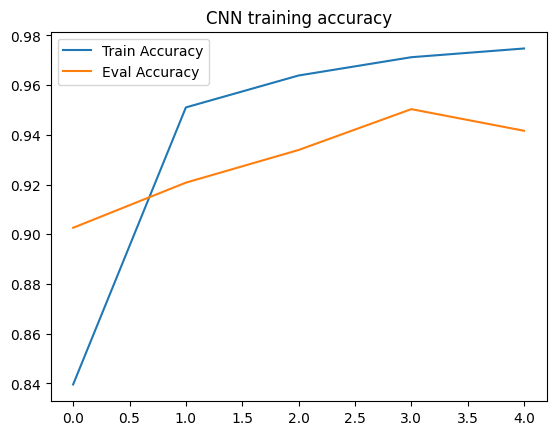

In [29]:
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["eval_acc"], label="Eval Accuracy")
plt.legend()
plt.title("CNN training accuracy")
plt.show()

## ViT

In [ ]:
import torch
from torch import nn
from torchvision.models.vision_transformer import VisionTransformer


class ViTClassifier(nn.Module):
    """
    Small Vision Transformer for 256x256 images, binary classification (Real/Fake).

    Uses torchvision.models.vision_transformer.VisionTransformer under the hood.
    """

    def __init__(
        self,
        image_size: int = 256,
        patch_size: int = 16,
        num_layers: int = 6,
        hidden_dim: int = 256,
        mlp_ratio: float = 4.0,
        dropout: float = 0.1,
        attention_dropout: float = 0.1,
        num_classes: int = 2,
    ):
        super().__init__()

        assert image_size % patch_size == 0, "image_size must be divisible by patch_size"
        self.image_size = image_size
        self.patch_size = patch_size

        # standard ViT practice: num_heads such that hidden_dim / num_heads ~ 64
        num_heads = max(1, hidden_dim // 64)
        mlp_dim = int(hidden_dim * mlp_ratio)

        self.vit = VisionTransformer(
            image_size=image_size,
            patch_size=patch_size,
            num_layers=num_layers,
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            mlp_dim=mlp_dim,
            dropout=dropout,
            attention_dropout=attention_dropout,
            num_classes=num_classes,
            representation_size=None,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.vit(x)


In [ ]:
from torch.optim import AdamW

def build_vit_model(
    arch: str = "small_vit",
    image_size: int = 256,
    patch_size: int = 16,
    num_layers: int = 6,
    hidden_dim: int = 256,
    mlp_ratio: float = 4.0,
    dropout: float = 0.1,
    attention_dropout: float = 0.1,
    num_classes: int = 2,
    **kwargs,
) -> nn.Module:
    """
    Wrapper compatible with run_ablation.
    `arch` is kept for consistency with the CNN setup.
    """
    if arch != "small_vit":
        raise ValueError(f"Unknown architecture: {arch}")

    return ViTClassifier(
        image_size=image_size,
        patch_size=patch_size,
        num_layers=num_layers,
        hidden_dim=hidden_dim,
        mlp_ratio=mlp_ratio,
        dropout=dropout,
        attention_dropout=attention_dropout,
        num_classes=num_classes,
    )


# ----------------------------
# MODEL hyperparameters (ViT)
# ----------------------------

vit_model_static = {
    "arch": "small_vit",
    "image_size": 256,
    "patch_size": 16,
    "num_classes": 2,
    "mlp_ratio": 4.0,
    "dropout": 0.1,
    "attention_dropout": 0.1,
}

vit_model_grid = {
    "hidden_dim": [192, 256],   # model width
    "num_layers": [6, 8],       # depth of transformer encoder
    # Could also add "patch_size": [16, 32] to explore fewer tokens
}


# ----------------------------
# TRAINING hyperparameters
# ----------------------------

vit_train_static = {
    "optimizer_cls": AdamW,
    "use_amp": True,
    "grad_clip_norm": 1.0,
    "batch_size": 32,
}

vit_train_grid = {
    "base_lr": [1e-4, 3e-4],
    "optimizer_kwargs": [
        {"weight_decay": 0.0},
        {"weight_decay": 1e-4},
    ],
}


NUM_EPOCHS = 5

from torch.utils.data import Subset
n_total = len(train_dataset)
n_small = n_total // 10
indices = torch.randperm(n_total)[:n_small]
train_dataset_subset = Subset(train_dataset, indices)

vit_results = run_ablation(
    build_model=build_vit_model,
    train_model_fn=train_model,
    train_dataset=train_dataset_subset,
    eval_dataset=val_dataset,
    model_static=vit_model_static,
    model_grid=vit_model_grid,
    train_static=vit_train_static,
    train_grid=vit_train_grid,
    num_epochs=NUM_EPOCHS,
    verbose=True,
)


Ablation: 4 model configs × 4 train configs = 16 runs

=== Run 1/16 ===
Model kwargs: {'arch': 'small_vit', 'image_size': 256, 'patch_size': 16, 'num_classes': 2, 'mlp_ratio': 4.0, 'dropout': 0.1, 'attention_dropout': 0.1, 'hidden_dim': 192, 'num_layers': 6}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0}} (epochs=5)


/tmp/ipython-input-2354787132.py:124: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

/tmp/ipython-input-2354787132.py:161: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

/tmp/ipython-input-2354787132.py:215: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 001/005 - train_loss: 0.6831, train_acc: 0.5561 - eval_loss: 0.6822, eval_acc: 0.5766


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6667, train_acc: 0.5992 - eval_loss: 0.6971, eval_acc: 0.5521


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.6538, train_acc: 0.6201 - eval_loss: 0.6632, eval_acc: 0.6046


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.6268, train_acc: 0.6459 - eval_loss: 0.6732, eval_acc: 0.6180


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.5978, train_acc: 0.6778 - eval_loss: 0.6058, eval_acc: 0.6712
Best eval acc this run: 0.6712 at epoch 5

=== Run 2/16 ===
Model kwargs: {'arch': 'small_vit', 'image_size': 256, 'patch_size': 16, 'num_classes': 2, 'mlp_ratio': 4.0, 'dropout': 0.1, 'attention_dropout': 0.1, 'hidden_dim': 192, 'num_layers': 6}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6801, train_acc: 0.5696 - eval_loss: 0.7021, eval_acc: 0.5472


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6671, train_acc: 0.5956 - eval_loss: 0.6707, eval_acc: 0.5892


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.6452, train_acc: 0.6257 - eval_loss: 0.6567, eval_acc: 0.6223


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.6199, train_acc: 0.6560 - eval_loss: 0.6074, eval_acc: 0.6755


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.5870, train_acc: 0.6889 - eval_loss: 0.6122, eval_acc: 0.6758
Best eval acc this run: 0.6758 at epoch 5

=== Run 3/16 ===
Model kwargs: {'arch': 'small_vit', 'image_size': 256, 'patch_size': 16, 'num_classes': 2, 'mlp_ratio': 4.0, 'dropout': 0.1, 'attention_dropout': 0.1, 'hidden_dim': 192, 'num_layers': 6}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0003, 'optimizer_kwargs': {'weight_decay': 0.0, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6811, train_acc: 0.5678 - eval_loss: 0.6846, eval_acc: 0.5499


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6699, train_acc: 0.5891 - eval_loss: 0.6866, eval_acc: 0.5686


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.6529, train_acc: 0.6171 - eval_loss: 0.6478, eval_acc: 0.6305


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.6263, train_acc: 0.6485 - eval_loss: 0.6340, eval_acc: 0.6317


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.5981, train_acc: 0.6795 - eval_loss: 0.5959, eval_acc: 0.6795
Best eval acc this run: 0.6795 at epoch 5

=== Run 4/16 ===
Model kwargs: {'arch': 'small_vit', 'image_size': 256, 'patch_size': 16, 'num_classes': 2, 'mlp_ratio': 4.0, 'dropout': 0.1, 'attention_dropout': 0.1, 'hidden_dim': 192, 'num_layers': 6}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0003, 'optimizer_kwargs': {'weight_decay': 0.0001, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6772, train_acc: 0.5753 - eval_loss: 0.6907, eval_acc: 0.5495


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6659, train_acc: 0.5993 - eval_loss: 0.6890, eval_acc: 0.5700


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.6526, train_acc: 0.6192 - eval_loss: 0.6663, eval_acc: 0.5929


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.6324, train_acc: 0.6452 - eval_loss: 0.6662, eval_acc: 0.6175


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.6103, train_acc: 0.6684 - eval_loss: 0.6359, eval_acc: 0.6401
Best eval acc this run: 0.6401 at epoch 5

=== Run 5/16 ===
Model kwargs: {'arch': 'small_vit', 'image_size': 256, 'patch_size': 16, 'num_classes': 2, 'mlp_ratio': 4.0, 'dropout': 0.1, 'attention_dropout': 0.1, 'hidden_dim': 192, 'num_layers': 8}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6828, train_acc: 0.5587 - eval_loss: 0.7088, eval_acc: 0.5103


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6687, train_acc: 0.5922 - eval_loss: 0.6924, eval_acc: 0.5491


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.6539, train_acc: 0.6155 - eval_loss: 0.6419, eval_acc: 0.6391


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.6387, train_acc: 0.6384 - eval_loss: 0.6280, eval_acc: 0.6463


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.6149, train_acc: 0.6617 - eval_loss: 0.6313, eval_acc: 0.6517
Best eval acc this run: 0.6517 at epoch 5

=== Run 6/16 ===
Model kwargs: {'arch': 'small_vit', 'image_size': 256, 'patch_size': 16, 'num_classes': 2, 'mlp_ratio': 4.0, 'dropout': 0.1, 'attention_dropout': 0.1, 'hidden_dim': 192, 'num_layers': 8}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0001, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6784, train_acc: 0.5714 - eval_loss: 0.7065, eval_acc: 0.5345


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6628, train_acc: 0.6050 - eval_loss: 0.6660, eval_acc: 0.6015


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.6460, train_acc: 0.6231 - eval_loss: 0.6460, eval_acc: 0.6426


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.6202, train_acc: 0.6524 - eval_loss: 0.6311, eval_acc: 0.6459


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.5933, train_acc: 0.6826 - eval_loss: 0.6430, eval_acc: 0.6333
Best eval acc this run: 0.6459 at epoch 4

=== Run 7/16 ===
Model kwargs: {'arch': 'small_vit', 'image_size': 256, 'patch_size': 16, 'num_classes': 2, 'mlp_ratio': 4.0, 'dropout': 0.1, 'attention_dropout': 0.1, 'hidden_dim': 192, 'num_layers': 8}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0003, 'optimizer_kwargs': {'weight_decay': 0.0, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6816, train_acc: 0.5664 - eval_loss: 0.6920, eval_acc: 0.5551


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6707, train_acc: 0.5946 - eval_loss: 0.6850, eval_acc: 0.5710


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.6535, train_acc: 0.6178 - eval_loss: 0.6470, eval_acc: 0.6200


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.6278, train_acc: 0.6441 - eval_loss: 0.6708, eval_acc: 0.6102


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.6004, train_acc: 0.6786 - eval_loss: 0.7163, eval_acc: 0.6196
Best eval acc this run: 0.6200 at epoch 3

=== Run 8/16 ===
Model kwargs: {'arch': 'small_vit', 'image_size': 256, 'patch_size': 16, 'num_classes': 2, 'mlp_ratio': 4.0, 'dropout': 0.1, 'attention_dropout': 0.1, 'hidden_dim': 192, 'num_layers': 8}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0003, 'optimizer_kwargs': {'weight_decay': 0.0001, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6789, train_acc: 0.5679 - eval_loss: 0.6953, eval_acc: 0.5730


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6593, train_acc: 0.6117 - eval_loss: 0.6657, eval_acc: 0.6097


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.6432, train_acc: 0.6325 - eval_loss: 0.6395, eval_acc: 0.6411


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.6217, train_acc: 0.6534 - eval_loss: 0.6158, eval_acc: 0.6616


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.5912, train_acc: 0.6859 - eval_loss: 0.6197, eval_acc: 0.6720
Best eval acc this run: 0.6720 at epoch 5

=== Run 9/16 ===
Model kwargs: {'arch': 'small_vit', 'image_size': 256, 'patch_size': 16, 'num_classes': 2, 'mlp_ratio': 4.0, 'dropout': 0.1, 'attention_dropout': 0.1, 'hidden_dim': 256, 'num_layers': 6}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6797, train_acc: 0.5718 - eval_loss: 0.6892, eval_acc: 0.5580


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6695, train_acc: 0.5924 - eval_loss: 0.6876, eval_acc: 0.5706


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 3/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 003/005 - train_loss: 0.6555, train_acc: 0.6134 - eval_loss: 0.6534, eval_acc: 0.6139


Train 4/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 4/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 004/005 - train_loss: 0.6316, train_acc: 0.6447 - eval_loss: 0.6253, eval_acc: 0.6541


Train 5/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 5/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 005/005 - train_loss: 0.6008, train_acc: 0.6729 - eval_loss: 0.6104, eval_acc: 0.6618
Best eval acc this run: 0.6618 at epoch 5

=== Run 10/16 ===
Model kwargs: {'arch': 'small_vit', 'image_size': 256, 'patch_size': 16, 'num_classes': 2, 'mlp_ratio': 4.0, 'dropout': 0.1, 'attention_dropout': 0.1, 'hidden_dim': 256, 'num_layers': 6}
Train kwargs: {'optimizer_cls': <class 'torch.optim.adamw.AdamW'>, 'use_amp': True, 'grad_clip_norm': 1.0, 'batch_size': 32, 'base_lr': 0.0001, 'optimizer_kwargs': {'weight_decay': 0.0001, 'lr': 0.0001}} (epochs=5)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Train 1/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 1/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 001/005 - train_loss: 0.6810, train_acc: 0.5654 - eval_loss: 0.6752, eval_acc: 0.5823


Train 2/5:   0%|          | 0/438 [00:00<?, ?it/s]

Eval 2/5:   0%|          | 0/1233 [00:00<?, ?it/s]

Epoch 002/005 - train_loss: 0.6707, train_acc: 0.5865 - eval_loss: 0.6965, eval_acc: 0.5030


Train 3/5:   0%|          | 0/438 [00:00<?, ?it/s]

# Test

Testing:   0%|          | 0/341 [00:00<?, ?it/s]

Test accuracy: 0.8549

Classification report:
              precision    recall  f1-score   support

        Fake       0.82      0.92      0.86      5492
        Real       0.90      0.79      0.84      5413

    accuracy                           0.85     10905
   macro avg       0.86      0.85      0.85     10905
weighted avg       0.86      0.85      0.85     10905



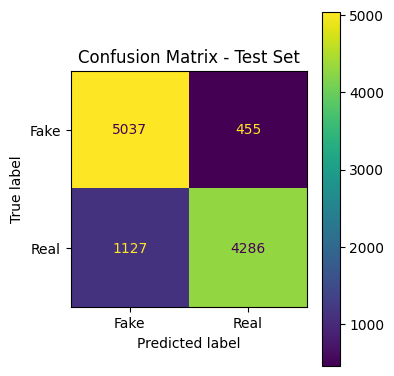


Total misclassified samples: 1582
  Real -> predicted Fake: 1127
  Fake -> predicted Real: 455


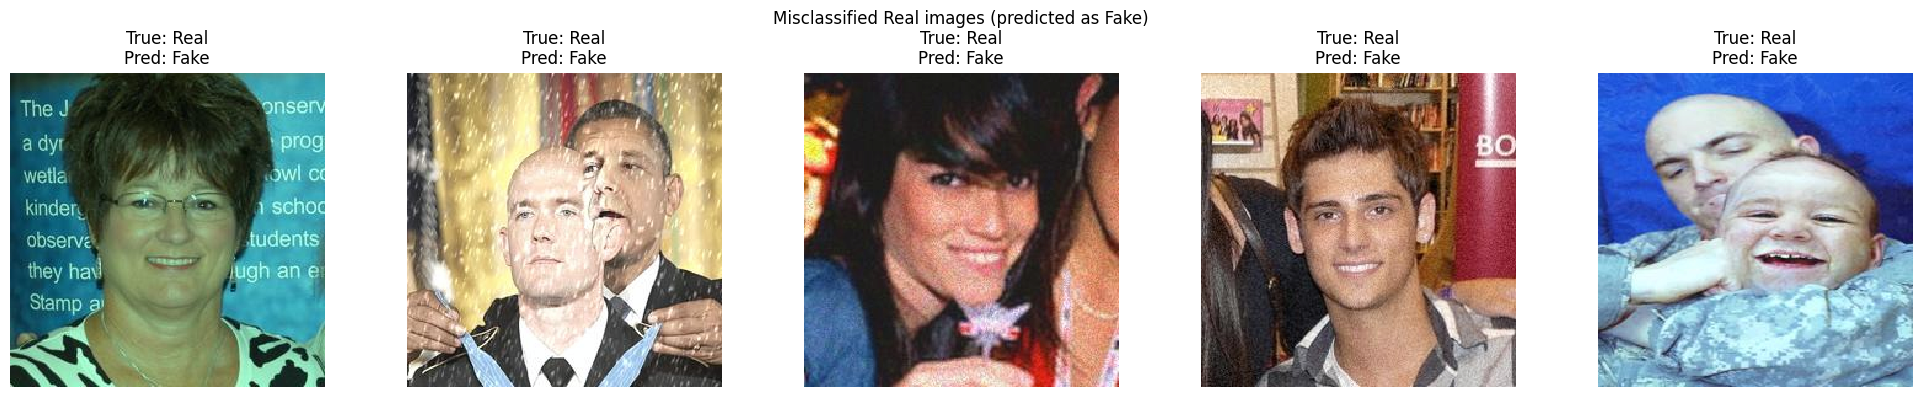

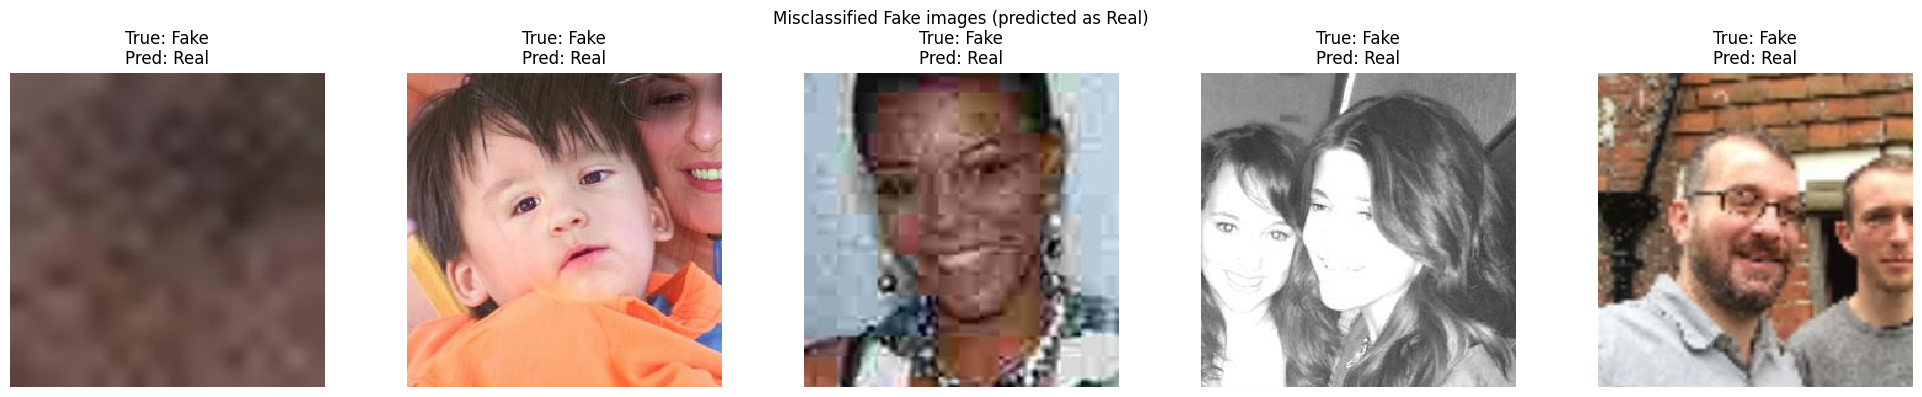

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from tqdm.auto import tqdm


CLASS_NAMES = {0: "Fake", 1: "Real"}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
cnn_model.eval()

all_labels = []
all_preds = []
all_probs = []


with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = cnn_model(inputs)            # [B, num_classes]
        probs = torch.softmax(outputs, dim=1)  # [B, num_classes]
        preds = probs.argmax(dim=1)            # [B]

        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs[:, 1].cpu())

all_labels = torch.cat(all_labels).numpy()
all_preds = torch.cat(all_preds).numpy()
all_probs = torch.cat(all_probs).numpy()

acc = accuracy_score(all_labels, all_preds)
print(f"Test accuracy: {acc:.4f}")

target_names = [CLASS_NAMES[i] for i in sorted(CLASS_NAMES.keys())]
print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax, values_format="d")
ax.set_title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    """
    img_tensor: CxHxW (torch.Tensor)
    Returns HxWxC numpy array, roughly back in [0, 1] range.
    """
    img = img_tensor.numpy()
    if img.ndim == 3 and img.shape[0] in (1, 3):
        img = np.transpose(img, (1, 2, 0))  # C,H,W -> H,W,C
    img = STD * img + MEAN  # undo normalization
    img = np.clip(img, 0, 1)
    return img

# Find misclassified indices
mis_idx = np.where(all_preds != all_labels)[0]

wrong_real_idx = [i for i in mis_idx if all_labels[i] == 1]  # true Real, predicted Fake
wrong_fake_idx = [i for i in mis_idx if all_labels[i] == 0]  # true Fake, predicted Real

print(f"\nTotal misclassified samples: {len(mis_idx)}")
print(f"  Real -> predicted Fake: {len(wrong_real_idx)}")
print(f"  Fake -> predicted Real: {len(wrong_fake_idx)}")

# How many examples per class to show
N_SAMPLES_PER_CLASS = 5

def plot_misclassified(indices, title_prefix):
    if len(indices) == 0:
        print(f"No misclassified samples for: {title_prefix}")
        return

    n_show = min(N_SAMPLES_PER_CLASS, len(indices))
    fig, axes = plt.subplots(1, n_show, figsize=(4 * n_show, 4))
    if n_show == 1:
        axes = [axes]

    for ax, idx in zip(axes, indices[:n_show]):
        img, label = test_dataset[idx]

        if isinstance(img, torch.Tensor):
            img_np = denormalize(img.cpu())
        else:
            img_np = np.array(img)

        ax.imshow(img_np, interpolation="nearest")
        ax.axis("off")

        true_label_name = CLASS_NAMES[int(all_labels[idx])]
        pred_label_name = CLASS_NAMES[int(all_preds[idx])]
        ax.set_title(f"True: {true_label_name}\nPred: {pred_label_name}")

    plt.suptitle(title_prefix)
    plt.tight_layout()
    plt.show()

# Plot wrongly classified Real samples (Real -> Fake)
plot_misclassified(
    wrong_real_idx,
    title_prefix="Misclassified Real images (predicted as Fake)"
)

# Plot wrongly classified Fake samples (Fake -> Real)
plot_misclassified(
    wrong_fake_idx,
    title_prefix="Misclassified Fake images (predicted as Real)"
)


In [17]:
!pip install pyiqa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 75.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.2/276.2 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 152.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226.4 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Loading pretrained model MUSIQ from /root/.cache/torch/hub/pyiqa/musiq_koniq_ckpt-e95806b9.pth
[OK] Using IQA metric: musiq
Loading pretrained model NIMA from /root/.cache/torch/hub/pyiqa/NIMA_InceptionV2_ava-b0c77c00.pth
[OK] Using IQA metric: nima
[OK] Using IQA metric: piqe
Loading pretrained model CFANet from /root/.cache/torch/hub/pyiqa/cfanet_nr_koniq_res50-9a73138b.pth
[OK] Using IQA metric: topiq_nr
Loading pretrained model UNIQUE from /root/.cache/torch/hub/pyiqa/UNIQUE.pt
[OK] Using IQA metric: unique
Loading pretrained model WaDIQaM from /root/.cache/torch/hub/pyiqa/WaDIQaM-NR-koniq-aaffea29.pth
[OK] Using IQA metric: wadiqam_nr


Computing IQA on test set:   0%|          | 0/341 [00:00<?, ?it/s]

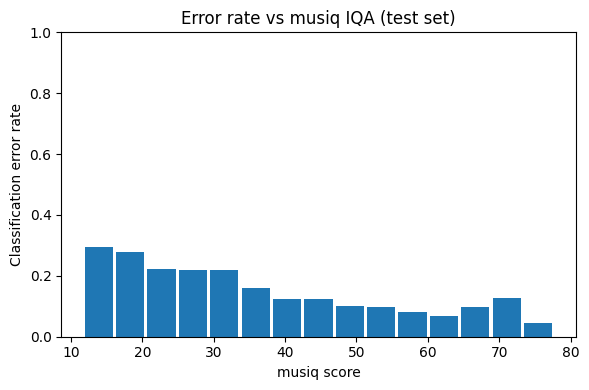

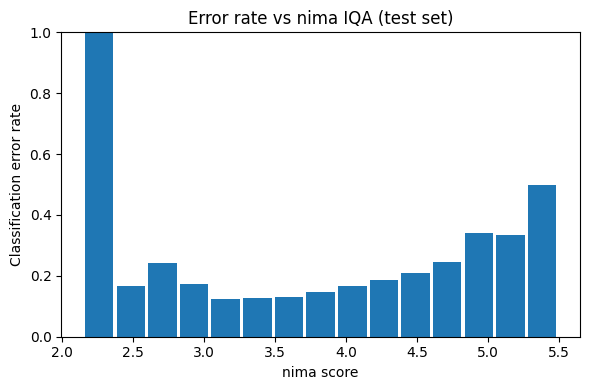

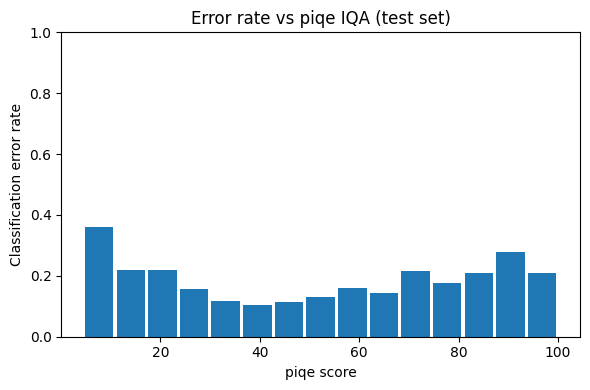

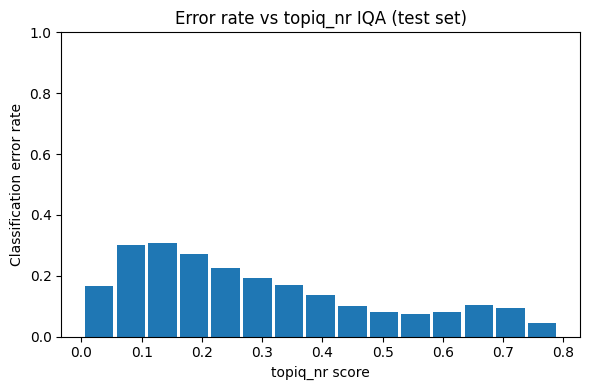

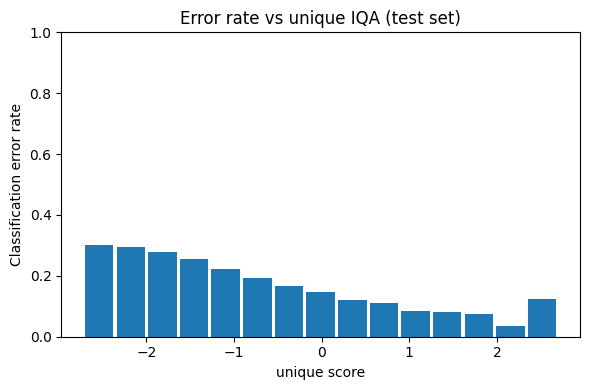

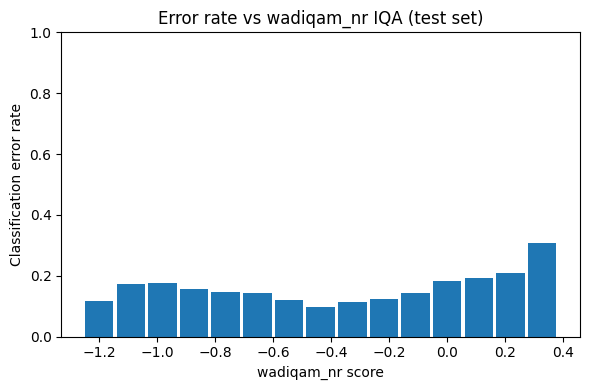

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pyiqa
from tqdm.auto import tqdm
import torch

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def to_0_1(batch: torch.Tensor) -> torch.Tensor:
    """
    batch: [B, C, H, W] tensor on any device.
    Returns a tensor in [0, 1].

    - If already in [0, 1], returns it unchanged.
    - Otherwise assumes ImageNet-style normalization and undoes it.
    """
    min_v = float(batch.min().item())
    max_v = float(batch.max().item())
    if 0.0 <= min_v and max_v <= 1.0:
        return batch  # already in the right range

    mean = torch.tensor(IMAGENET_MEAN, device=batch.device).view(1, 3, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=batch.device).view(1, 3, 1, 1)
    batch_01 = (batch * std + mean).clamp(0.0, 1.0)
    return batch_01


iqa_metric_names = [
    "musiq",
    "nima",
    "piqe",
    "topiq_nr",
    "unique",
    "wadiqam_nr",
]

iqa_metrics = {}
for name in iqa_metric_names:
    try:
        metric = pyiqa.create_metric(name, device=device)
        iqa_metrics[name] = metric
        print(f"[OK] Using IQA metric: {name}")
    except Exception as e:
        print(f"[SKIP] Could not create IQA metric '{name}': {e}")

if not iqa_metrics:
    raise RuntimeError("No IQA metrics available; aborting IQA analysis.")


num_test = len(test_dataset)
iqa_scores = {name: np.zeros(num_test, dtype=np.float32) for name in iqa_metrics.keys()}

idx = 0
with torch.no_grad():
    for batch_inputs, batch_labels in tqdm(test_loader, desc="Computing IQA on test set"):
        batch_inputs = batch_inputs.to(device)          # [B, C, H, W]
        batch_inputs_01 = to_0_1(batch_inputs)          # ensure [0, 1]

        b = batch_inputs_01.size(0)
        for i in range(b):
            img = batch_inputs_01[i:i+1]                # [1, C, H, W]
            for name, metric in iqa_metrics.items():
                try:
                    val = metric(img)
                    if torch.is_tensor(val):
                        val = float(val.mean().item())
                    else:
                        val = float(val)
                    iqa_scores[name][idx] = val
                except Exception as e:
                    print(f"[WARN] {name} failed on sample {idx}: {e}")
                    iqa_scores[name][idx] = np.nan
            idx += 1

assert idx == num_test, f"Scored {idx} samples but test set has {num_test}"


error_flags = (all_preds != all_labels).astype(np.float32)

NUM_BINS = 15

for name, vals in iqa_scores.items():
    vals = np.asarray(vals, dtype=np.float32)
    mask = np.isfinite(vals)
    vals = vals[mask]
    errs = error_flags[mask]

    if vals.size == 0:
        print(f"[SKIP PLOT] {name}: no valid scores.")
        continue

    vmin, vmax = float(vals.min()), float(vals.max())
    if vmin == vmax:
        print(f"[SKIP PLOT] {name}: constant IQA value.")
        continue

    bin_edges = np.linspace(vmin, vmax, NUM_BINS + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_idx = np.digitize(vals, bin_edges) - 1   # 0..NUM_BINS-1

    error_rate = np.full(NUM_BINS, np.nan, dtype=np.float32)
    counts = np.zeros(NUM_BINS, dtype=np.int32)

    for b in range(NUM_BINS):
        m = bin_idx == b
        if np.any(m):
            error_rate[b] = errs[m].mean()
            counts[b] = int(m.sum())

    valid = np.isfinite(error_rate) & (counts > 0)
    if not np.any(valid):
        print(f"[SKIP PLOT] {name}: no populated bins.")
        continue

    bar_width = (bin_edges[1] - bin_edges[0]) * 0.9

    plt.figure(figsize=(6, 4))
    plt.bar(bin_centers[valid], error_rate[valid], width=bar_width)
    plt.xlabel(f"{name} score")
    plt.ylabel("Classification error rate")
    plt.ylim(0.0, 1.0)
    plt.title(f"Error rate vs {name} IQA (test set)")
    plt.tight_layout()
    plt.show()


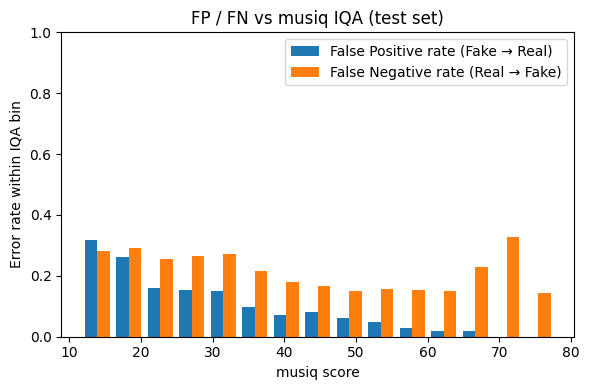

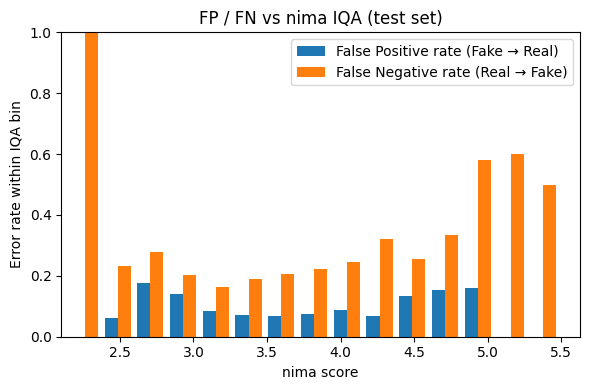

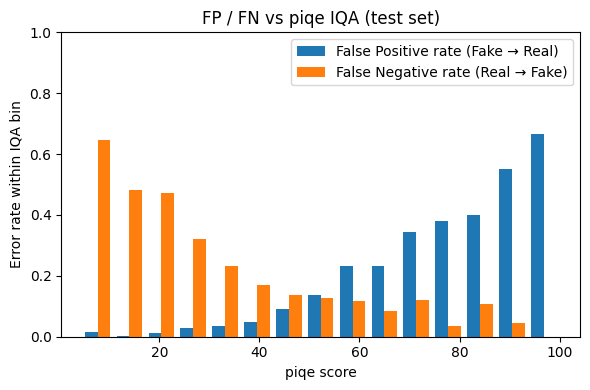

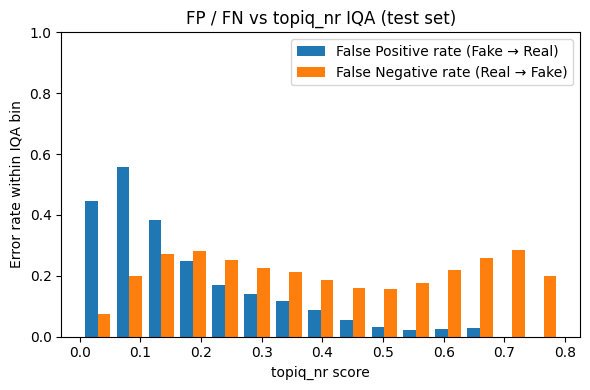

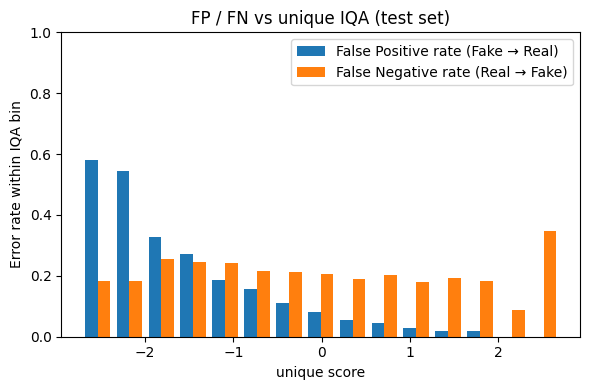

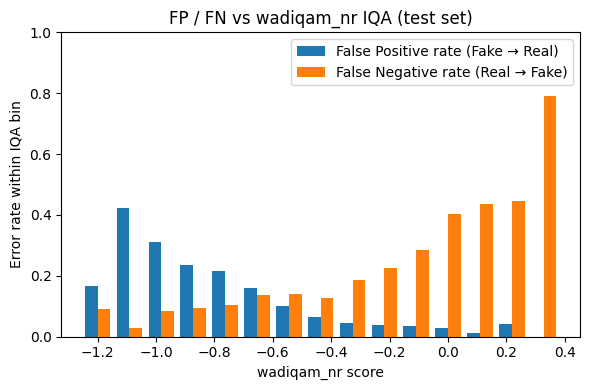

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Make sure these are numpy arrays
y_true_all = np.asarray(all_labels, dtype=int)
y_pred_all = np.asarray(all_preds, dtype=int)

# Convention: Real = positive class (1), Fake = negative class (0)
POS_LABEL = 1  # Real
NEG_LABEL = 0  # Fake

NUM_BINS = 15

for name, vals in iqa_scores.items():
    vals = np.asarray(vals, dtype=np.float32)

    # Drop NaNs (images that failed for this IQA metric)
    mask = np.isfinite(vals)
    vals = vals[mask]
    y_true = y_true_all[mask]
    y_pred = y_pred_all[mask]

    if vals.size == 0:
        print(f"[SKIP PLOT] {name}: no valid IQA scores.")
        continue

    vmin, vmax = float(vals.min()), float(vals.max())
    if vmin == vmax:
        print(f"[SKIP PLOT] {name}: constant IQA value across test samples.")
        continue

    # Bin IQA scores
    bin_edges = np.linspace(vmin, vmax, NUM_BINS + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_idx = np.digitize(vals, bin_edges) - 1  # 0..NUM_BINS-1

    fp_rate = np.full(NUM_BINS, np.nan, dtype=np.float32)
    fn_rate = np.full(NUM_BINS, np.nan, dtype=np.float32)
    neg_counts = np.zeros(NUM_BINS, dtype=int)  # #Fake per bin
    pos_counts = np.zeros(NUM_BINS, dtype=int)  # #Real per bin

    for b in range(NUM_BINS):
        in_bin = bin_idx == b
        if not np.any(in_bin):
            continue

        # ----- False Positive rate in this IQA bin -----
        # Condition on true negatives (Fake)
        neg_mask = in_bin & (y_true == NEG_LABEL)
        neg_counts[b] = int(neg_mask.sum())
        if neg_counts[b] > 0:
            # FP: Fake predicted as Real
            fp = np.sum(y_pred[neg_mask] == POS_LABEL)
            fp_rate[b] = fp / float(neg_counts[b])

        # ----- False Negative rate in this IQA bin -----
        # Condition on true positives (Real)
        pos_mask = in_bin & (y_true == POS_LABEL)
        pos_counts[b] = int(pos_mask.sum())
        if pos_counts[b] > 0:
            # FN: Real predicted as Fake
            fn = np.sum(y_pred[pos_mask] == NEG_LABEL)
            fn_rate[b] = fn / float(pos_counts[b])

    valid_fp = np.isfinite(fp_rate) & (neg_counts > 0)
    valid_fn = np.isfinite(fn_rate) & (pos_counts > 0)

    if not (np.any(valid_fp) or np.any(valid_fn)):
        print(f"[SKIP PLOT] {name}: no bins with Real/Fake data.")
        continue

    bar_width = (bin_edges[1] - bin_edges[0]) * 0.4

    plt.figure(figsize=(6, 4))

    # Side-by-side bars for FP and FN rates
    if np.any(valid_fp):
        plt.bar(
            bin_centers[valid_fp] - bar_width / 2,
            fp_rate[valid_fp],
            width=bar_width,
            label="False Positive rate (Fake → Real)",
        )
    if np.any(valid_fn):
        plt.bar(
            bin_centers[valid_fn] + bar_width / 2,
            fn_rate[valid_fn],
            width=bar_width,
            label="False Negative rate (Real → Fake)",
        )

    plt.xlabel(f"{name} score")
    plt.ylabel("Error rate within IQA bin")
    plt.ylim(0.0, 1.0)
    plt.title(f"FP / FN vs {name} IQA (test set)")
    plt.legend()
    plt.tight_layout()
    plt.show()


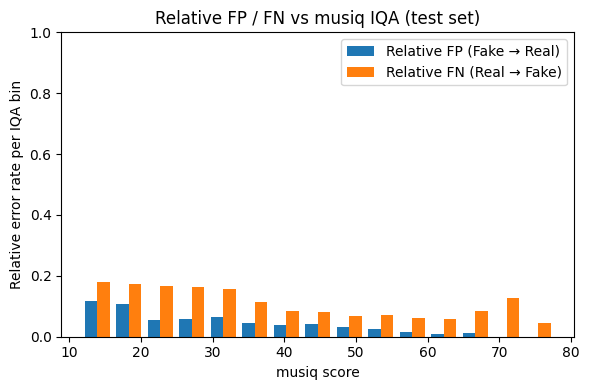

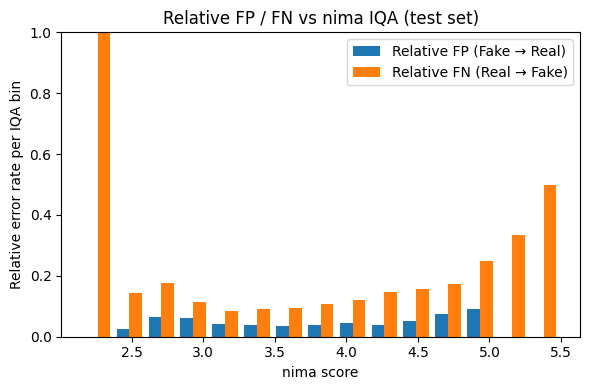

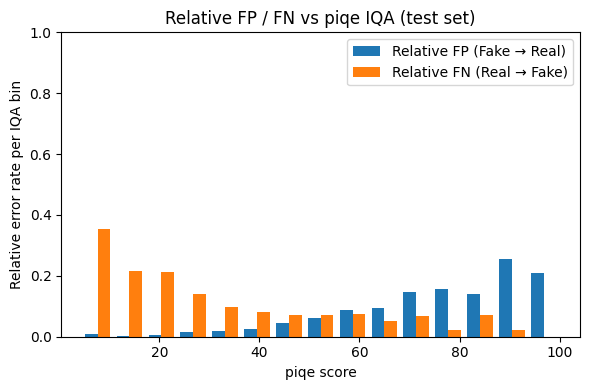

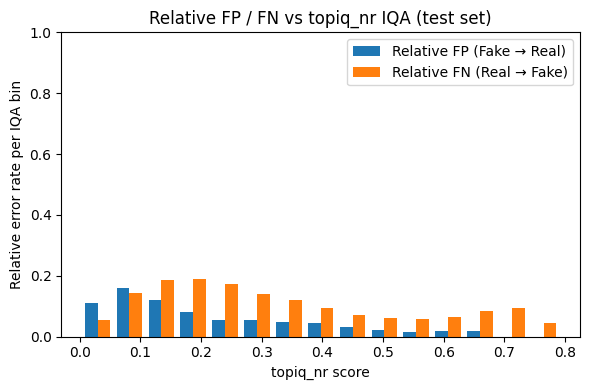

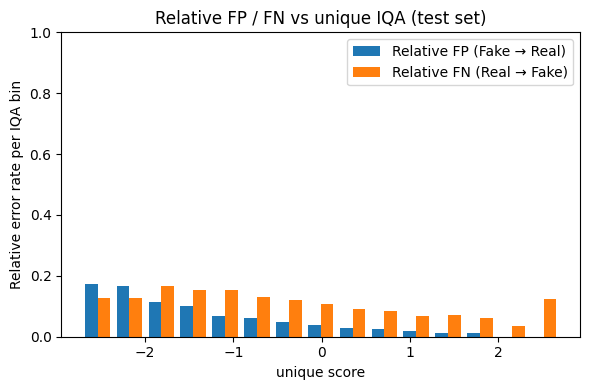

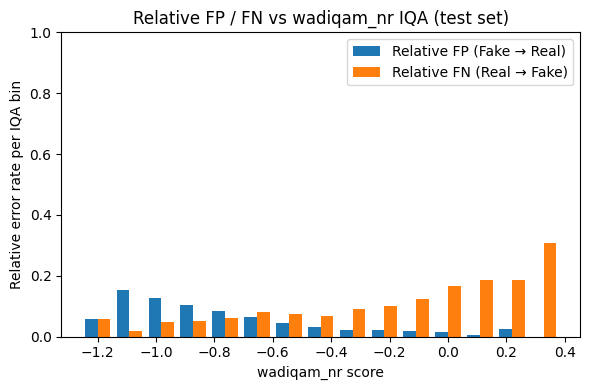

In [23]:
# ---------------------------------------------------
# 3. Plot relative FP / FN vs IQA score (per-bin)
#     FP / FN are normalized by total samples in bin
# ---------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Ensure numpy arrays
y_true_all = np.asarray(all_labels, dtype=int)
y_pred_all = np.asarray(all_preds, dtype=int)

NEG_LABEL = 0  # Fake
POS_LABEL = 1  # Real

NUM_BINS = 15  # tweak if you want finer/coarser IQA bins

for name, vals in iqa_scores.items():
    vals = np.asarray(vals, dtype=np.float32)

    # Drop NaNs (images that failed for this IQA metric)
    mask = np.isfinite(vals)
    vals = vals[mask]
    y_true = y_true_all[mask]
    y_pred = y_pred_all[mask]

    if vals.size == 0:
        print(f"[SKIP PLOT] {name}: no valid IQA scores.")
        continue

    vmin, vmax = float(vals.min()), float(vals.max())
    if vmin == vmax:
        print(f"[SKIP PLOT] {name}: constant IQA value across test samples.")
        continue

    # Bin IQA scores
    bin_edges = np.linspace(vmin, vmax, NUM_BINS + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    bin_idx = np.digitize(vals, bin_edges) - 1  # 0..NUM_BINS-1

    # Relative (per-bin) FP/FN rates:
    #   FP_rel(b) = #FP_in_bin / #samples_in_bin
    #   FN_rel(b) = #FN_in_bin / #samples_in_bin
    fp_rel = np.full(NUM_BINS, np.nan, dtype=np.float32)
    fn_rel = np.full(NUM_BINS, np.nan, dtype=np.float32)
    bin_counts = np.zeros(NUM_BINS, dtype=int)

    for b in range(NUM_BINS):
        in_bin = bin_idx == b
        if not np.any(in_bin):
            continue

        bin_counts[b] = int(in_bin.sum())

        # false positives: true Fake, predicted Real
        fp = np.sum((y_true == NEG_LABEL) & (y_pred == POS_LABEL) & in_bin)

        # false negatives: true Real, predicted Fake
        fn = np.sum((y_true == POS_LABEL) & (y_pred == NEG_LABEL) & in_bin)

        # normalize by total samples in this bin
        fp_rel[b] = fp / float(bin_counts[b])
        fn_rel[b] = fn / float(bin_counts[b])

    valid = (bin_counts > 0) & (np.isfinite(fp_rel) | np.isfinite(fn_rel))
    if not np.any(valid):
        print(f"[SKIP PLOT] {name}: no populated bins.")
        continue

    bar_width = (bin_edges[1] - bin_edges[0]) * 0.4

    plt.figure(figsize=(6, 4))

    # Side-by-side bars: FP_rel and FN_rel per bin
    if np.any(np.isfinite(fp_rel[valid])):
        plt.bar(
            bin_centers[valid] - bar_width / 2,
            fp_rel[valid],
            width=bar_width,
            label="Relative FP (Fake → Real)",
        )

    if np.any(np.isfinite(fn_rel[valid])):
        plt.bar(
            bin_centers[valid] + bar_width / 2,
            fn_rel[valid],
            width=bar_width,
            label="Relative FN (Real → Fake)",
        )

    plt.xlabel(f"{name} score")
    plt.ylabel("Relative error rate per IQA bin")
    plt.ylim(0.0, 1.0)
    plt.title(f"Relative FP / FN vs {name} IQA (test set)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [27]:
import numpy as np
from scipy.stats import pearsonr, ttest_ind

y_true_all = np.asarray(all_labels, dtype=int)
y_pred_all = np.asarray(all_preds, dtype=int)

NEG_LABEL = 0  # Fake
POS_LABEL = 1  # Real

metrics_to_test = ["piqe", "wadiqam_nr"]

for name in metrics_to_test:
    print(f"\n================= {name} =================")
    scores = np.asarray(iqa_scores[name], dtype=float)

    # Drop NaNs if any
    mask = np.isfinite(scores)
    scores = scores[mask]
    y_true = y_true_all[mask]
    y_pred = y_pred_all[mask]

    # --------------------------------------------------
    # A) Fake images: IQA vs False Positives (Fake -> Real)
    # --------------------------------------------------
    fake_mask = (y_true == NEG_LABEL)
    x_fake = scores[fake_mask]
    y_pred_fake = y_pred[fake_mask]

    if x_fake.size > 0:
        is_fp = (y_pred_fake == POS_LABEL).astype(int)  # 1 = FP, 0 = TN

        # Pearson correlation (point-biserial)
        r_fp, p_fp = pearsonr(x_fake, is_fp)
        print(f"[Fake] Pearson(IQA, FP)   r = {r_fp:.3f}, p = {p_fp:.3g}")

        # t-test: IQA of FP vs TN
        x_fp = x_fake[is_fp == 1]
        x_tn = x_fake[is_fp == 0]
        if x_fp.size > 1 and x_tn.size > 1:
            t_fp, p_t_fp = ttest_ind(x_fp, x_tn, equal_var=False)
            print(
                f"[Fake] t-test(FP vs TN): t = {t_fp:.3f}, p = {p_t_fp:.3g}, "
                f"mean_FP = {x_fp.mean():.3f}, mean_TN = {x_tn.mean():.3f}"
            )
        else:
            print("[Fake] Not enough FP or TN for t-test.")
    else:
        print("[Fake] No Fake samples for this metric.")

    # --------------------------------------------------
    # B) Real images: IQA vs False Negatives (Real -> Fake)
    # --------------------------------------------------
    real_mask = (y_true == POS_LABEL)
    x_real = scores[real_mask]
    y_pred_real = y_pred[real_mask]

    if x_real.size > 0:
        is_fn = (y_pred_real == NEG_LABEL).astype(int)  # 1 = FN, 0 = TP

        # Pearson correlation
        r_fn, p_fn = pearsonr(x_real, is_fn)
        print(f"[Real] Pearson(IQA, FN)   r = {r_fn:.3f}, p = {p_fn:.3g}")

        # t-test: IQA of FN vs TP
        x_fn = x_real[is_fn == 1]
        x_tp = x_real[is_fn == 0]
        if x_fn.size > 1 and x_tp.size > 1:
            t_fn, p_t_fn = ttest_ind(x_fn, x_tp, equal_var=False)
            print(
                f"[Real] t-test(FN vs TP): t = {t_fn:.3f}, p = {p_t_fn:.3g}, "
                f"mean_FN = {x_fn.mean():.3f}, mean_TP = {x_tp.mean():.3f}"
            )
        else:
            print("[Real] Not enough FN or TP for t-test.")
    else:
        print("[Real] No Real samples for this metric.")



================= piqe =================
[Fake] Pearson(IQA, FP)   r = 0.313, p = 3.28e-125
[Fake] t-test(FP vs TN): t = 20.397, p = 5.13e-68, mean_FP = 54.871, mean_TN = 37.804
[Real] Pearson(IQA, FN)   r = -0.270, p = 5.77e-91
[Real] t-test(FN vs TP): t = -21.194, p = 2.45e-89, mean_FN = 33.927, mean_TP = 44.876

================= wadiqam_nr =================
[Fake] Pearson(IQA, FP)   r = -0.278, p = 6.02e-98
[Fake] t-test(FP vs TN): t = -20.446, p = 6.23e-69, mean_FP = -0.618, mean_TN = -0.286
[Real] Pearson(IQA, FN)   r = 0.274, p = 6.02e-94
[Real] t-test(FN vs TP): t = 21.559, p = 4.75e-92, mean_FN = -0.220, mean_TP = -0.450


# correctly classified Fake images: 5037
# correctly classified Real images: 4286


Noise σ=0.000:   0%|          | 0/9323 [00:00<?, ?it/s]

Noise σ=0.000 → Fake-accuracy: 1.0000, Real-accuracy: 1.0000


Noise σ=0.020:   0%|          | 0/9323 [00:00<?, ?it/s]

Noise σ=0.020 → Fake-accuracy: 0.9960, Real-accuracy: 0.8266


Noise σ=0.050:   0%|          | 0/9323 [00:00<?, ?it/s]

Noise σ=0.050 → Fake-accuracy: 0.9867, Real-accuracy: 0.1755


Noise σ=0.100:   0%|          | 0/9323 [00:00<?, ?it/s]

Noise σ=0.100 → Fake-accuracy: 0.9837, Real-accuracy: 0.0420


Noise σ=0.150:   0%|          | 0/9323 [00:00<?, ?it/s]

Noise σ=0.150 → Fake-accuracy: 0.9952, Real-accuracy: 0.0089


Noise σ=0.200:   0%|          | 0/9323 [00:00<?, ?it/s]

Noise σ=0.200 → Fake-accuracy: 0.9998, Real-accuracy: 0.0019


Noise σ=0.300:   0%|          | 0/9323 [00:00<?, ?it/s]

Noise σ=0.300 → Fake-accuracy: 1.0000, Real-accuracy: 0.0000


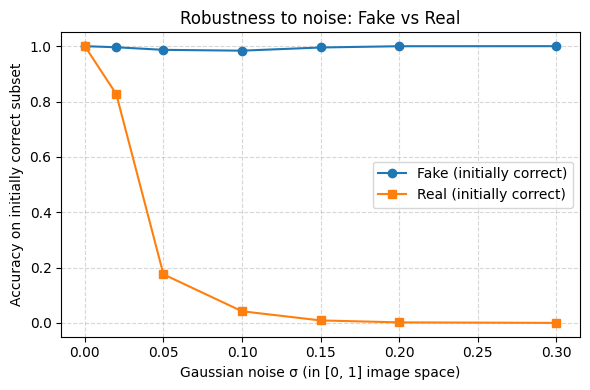

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ---------------------------------------------------
# Config: noise levels (in [0, 1] image space)
# ---------------------------------------------------
noise_sigmas = [0.0, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3]

# Adjust if you used different normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

NEG_LABEL = 0  # Fake
POS_LABEL = 1  # Real

# ---------------------------------------------------
# Helpers: normalized <-> [0, 1] image space
# ---------------------------------------------------
def denorm_to_01(img: torch.Tensor) -> torch.Tensor:
    """
    img: [B, C, H, W] tensor in normalized space.
    Returns [B, C, H, W] tensor in [0, 1].
    """
    mean = torch.tensor(IMAGENET_MEAN, device=img.device).view(1, -1, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=img.device).view(1, -1, 1, 1)
    return (img * std + mean).clamp(0.0, 1.0)

def renorm_from_01(img01: torch.Tensor) -> torch.Tensor:
    """
    img01: [B, C, H, W] tensor in [0, 1].
    Returns [B, C, H, W] tensor in normalized space.
    """
    mean = torch.tensor(IMAGENET_MEAN, device=img01.device).view(1, -1, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=img01.device).view(1, -1, 1, 1)
    return (img01 - mean) / std

# ---------------------------------------------------
# 1) Find correctly classified Fake and Real images
# ---------------------------------------------------
all_labels_np = np.asarray(all_labels, dtype=int)
all_preds_np  = np.asarray(all_preds, dtype=int)

correct_fake_indices = np.where(
    (all_labels_np == NEG_LABEL) & (all_preds_np == NEG_LABEL)
)[0]

correct_real_indices = np.where(
    (all_labels_np == POS_LABEL) & (all_preds_np == POS_LABEL)
)[0]

print(f"# correctly classified Fake images: {len(correct_fake_indices)}")
print(f"# correctly classified Real images: {len(correct_real_indices)}")

if len(correct_fake_indices) == 0 and len(correct_real_indices) == 0:
    print("No correctly classified Fake or Real images found; nothing to test.")
else:
    num_test = len(test_dataset)

    # Boolean masks for quick membership test by dataset index
    is_correct_fake = np.zeros(num_test, dtype=bool)
    is_correct_real = np.zeros(num_test, dtype=bool)
    is_correct_fake[correct_fake_indices] = True
    is_correct_real[correct_real_indices] = True

    # Union of both subsets = images we actually evaluate
    subset_indices = np.where(is_correct_fake | is_correct_real)[0]

    total_fake = len(correct_fake_indices)
    total_real = len(correct_real_indices)

    cnn_model.eval()
    accuracies_fake = []
    accuracies_real = []

    # ---------------------------------------------------
    # 2) Sweep over noise strengths
    # ---------------------------------------------------
    for sigma in noise_sigmas:
        correct_fake = 0
        correct_real = 0

        loop = tqdm(subset_indices,
                    desc=f"Noise σ={sigma:.3f}",
                    leave=False)

        with torch.no_grad():
            for idx in loop:
                img, label = test_dataset[int(idx)]   # img: [C, H, W]
                img = img.unsqueeze(0).to(device)     # [1, C, H, W]

                # Convert to [0, 1] space
                img_01 = denorm_to_01(img)

                # Add Gaussian noise in [0, 1]
                if sigma > 0.0:
                    noise = sigma * torch.randn_like(img_01)
                    noisy_01 = (img_01 + noise).clamp(0.0, 1.0)
                else:
                    noisy_01 = img_01  # baseline, no noise

                # Back to normalized space for the model
                noisy_norm = renorm_from_01(noisy_01)

                # Predict
                outputs = cnn_model(noisy_norm)
                pred = outputs.argmax(dim=1).item()

                # Update accuracy counters separately for the two subsets
                if is_correct_fake[idx]:
                    # Initially a correctly classified Fake (label 0)
                    if pred == NEG_LABEL:
                        correct_fake += 1

                if is_correct_real[idx]:
                    # Initially a correctly classified Real (label 1)
                    if pred == POS_LABEL:
                        correct_real += 1

        acc_fake = (correct_fake / total_fake) if total_fake > 0 else float("nan")
        acc_real = (correct_real / total_real) if total_real > 0 else float("nan")

        accuracies_fake.append(acc_fake)
        accuracies_real.append(acc_real)

        print(
            f"Noise σ={sigma:.3f} → "
            f"Fake-accuracy: {acc_fake:.4f}, "
            f"Real-accuracy: {acc_real:.4f}"
        )

    # ---------------------------------------------------
    # 3) Plot overlay: accuracy vs noise for Fake & Real
    # ---------------------------------------------------
    plt.figure(figsize=(6, 4))
    if total_fake > 0:
        plt.plot(noise_sigmas, accuracies_fake, marker="o", label="Fake (initially correct)")
    if total_real > 0:
        plt.plot(noise_sigmas, accuracies_real, marker="s", label="Real (initially correct)")

    plt.xlabel("Gaussian noise σ (in [0, 1] image space)")
    plt.ylabel("Accuracy on initially correct subset")
    plt.title("Robustness to noise: Fake vs Real")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


# correctly classified Real images: 4286


Searching for Real → misclassified at σ=0.05:   0%|          | 0/4286 [00:00<?, ?it/s]

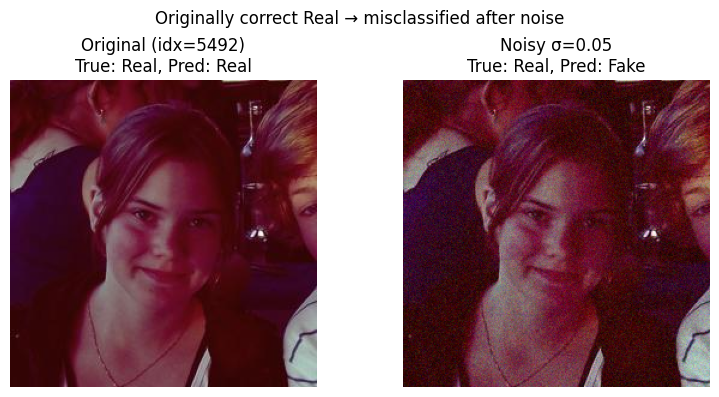

In [35]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ---------------------------------------------------
# Assumptions / config
# ---------------------------------------------------
POS_LABEL = 1  # Real
NEG_LABEL = 0  # Fake

# If not already defined, define ImageNet stats and helpers:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def denorm_to_01(img: torch.Tensor) -> torch.Tensor:
    """
    img: [B, C, H, W] tensor in normalized space.
    Returns [B, C, H, W] tensor in [0, 1].
    """
    mean = torch.tensor(IMAGENET_MEAN, device=img.device).view(1, -1, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=img.device).view(1, -1, 1, 1)
    return (img * std + mean).clamp(0.0, 1.0)

def renorm_from_01(img01: torch.Tensor) -> torch.Tensor:
    """
    img01: [B, C, H, W] tensor in [0, 1].
    Returns [B, C, H, W] tensor in normalized space.
    """
    mean = torch.tensor(IMAGENET_MEAN, device=img01.device).view(1, -1, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=img01.device).view(1, -1, 1, 1)
    return (img01 - mean) / std

idx_to_class = {0: "Fake", 1: "Real"}

# ---------------------------------------------------
# Find originally correctly classified Real images
# ---------------------------------------------------
all_labels_np = np.asarray(all_labels, dtype=int)
all_preds_np  = np.asarray(all_preds, dtype=int)

correct_real_indices = np.where(
    (all_labels_np == POS_LABEL) & (all_preds_np == POS_LABEL)
)[0]

print(f"# correctly classified Real images: {len(correct_real_indices)}")

if len(correct_real_indices) == 0:
    print("No correctly classified Real images found; cannot perform this visualization.")
else:
    sigma = 0.05  # noise level requested
    found = False
    example = None  # will hold (orig_img_01, noisy_img_01, orig_pred, noisy_pred, idx)

    cnn_model.eval()

    with torch.no_grad():
        for idx in tqdm(correct_real_indices,
                        desc=f"Searching for Real → misclassified at σ={sigma}",
                        leave=False):
            img, label = test_dataset[int(idx)]   # img: [C, H, W]
            # label should be POS_LABEL by construction

            img_batch = img.unsqueeze(0).to(device)  # [1, C, H, W]

            # Confirm original prediction (for sanity)
            outputs_orig = cnn_model(img_batch)
            pred_orig = outputs_orig.argmax(dim=1).item()

            if pred_orig != POS_LABEL:
                # In principle shouldn't happen for this subset, but be safe
                continue

            # Convert to [0, 1]
            img_01 = denorm_to_01(img_batch)

            # Add Gaussian noise in [0, 1]
            noise = sigma * torch.randn_like(img_01)
            noisy_01 = (img_01 + noise).clamp(0.0, 1.0)

            # Back to normalized space for model
            noisy_norm = renorm_from_01(noisy_01)

            # Predict on noisy image
            outputs_noisy = cnn_model(noisy_norm)
            pred_noisy = outputs_noisy.argmax(dim=1).item()

            # Check if it gets misclassified after noise
            if pred_noisy != POS_LABEL:
                # Store this example
                example = (
                    img_01.squeeze(0).cpu(),      # [C, H, W]
                    noisy_01.squeeze(0).cpu(),    # [C, H, W]
                    pred_orig,
                    pred_noisy,
                    idx,
                )
                found = True
                break

    if not found or example is None:
        print(f"No Real image found that flips from correct → misclassified at σ={sigma}.")
    else:
        orig_01, noisy_01, pred_orig, pred_noisy, idx = example

        # Prepare for plotting: C,H,W -> H,W,C
        def to_hwcn(t: torch.Tensor):
            arr = t.numpy()
            if arr.shape[0] in (1, 3):
                arr = np.transpose(arr, (1, 2, 0))
            return arr

        orig_img_plot  = to_hwcn(orig_01)
        noisy_img_plot = to_hwcn(noisy_01)

        plt.figure(figsize=(8, 4))

        # Original
        plt.subplot(1, 2, 1)
        plt.imshow(orig_img_plot)
        plt.axis("off")
        plt.title(
            f"Original (idx={idx})\n"
            f"True: Real, Pred: {idx_to_class[pred_orig]}"
        )

        # Noisy
        plt.subplot(1, 2, 2)
        plt.imshow(noisy_img_plot)
        plt.axis("off")
        plt.title(
            f"Noisy σ={sigma}\n"
            f"True: Real, Pred: {idx_to_class[pred_noisy]}"
        )

        plt.suptitle("Originally correct Real → misclassified after noise")
        plt.tight_layout()
        plt.show()

# correctly classified Fake images: 5037
# correctly classified Real images: 4286


JPEG quality=100:   0%|          | 0/9323 [00:00<?, ?it/s]

JPEG quality=100 → Fake-accuracy: 0.9974, Real-accuracy: 0.9942


JPEG quality=95:   0%|          | 0/9323 [00:00<?, ?it/s]

JPEG quality=95 → Fake-accuracy: 0.9982, Real-accuracy: 0.9935


JPEG quality=85:   0%|          | 0/9323 [00:00<?, ?it/s]

JPEG quality=85 → Fake-accuracy: 0.9990, Real-accuracy: 0.9578


JPEG quality=75:   0%|          | 0/9323 [00:00<?, ?it/s]

JPEG quality=75 → Fake-accuracy: 0.9992, Real-accuracy: 0.9988


JPEG quality=60:   0%|          | 0/9323 [00:00<?, ?it/s]

JPEG quality=60 → Fake-accuracy: 0.9980, Real-accuracy: 0.8425


JPEG quality=40:   0%|          | 0/9323 [00:00<?, ?it/s]

JPEG quality=40 → Fake-accuracy: 0.9803, Real-accuracy: 0.9459


JPEG quality=20:   0%|          | 0/9323 [00:00<?, ?it/s]

JPEG quality=20 → Fake-accuracy: 0.9909, Real-accuracy: 0.8220


JPEG quality=10:   0%|          | 0/9323 [00:00<?, ?it/s]

JPEG quality=10 → Fake-accuracy: 0.9962, Real-accuracy: 0.4858


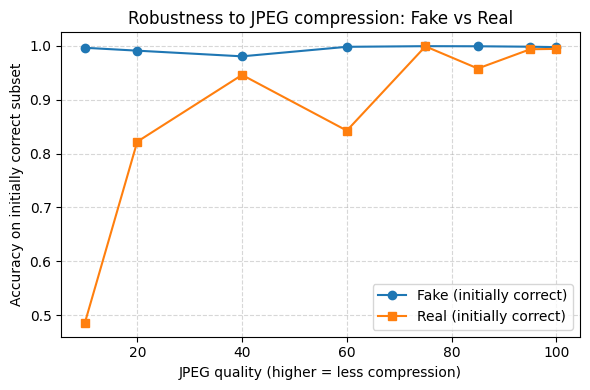

In [32]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import io
import torchvision.transforms.functional as F

# ---------------------------------------------------
# JPEG quality levels (higher = better quality)
# ---------------------------------------------------
jpeg_qualities = [100, 95, 85, 75, 60, 40, 20, 10]

# Adjust if you used different normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

NEG_LABEL = 0  # Fake
POS_LABEL = 1  # Real

# ---------------------------------------------------
# Helpers: normalized <-> [0, 1] image space
# ---------------------------------------------------
def denorm_to_01(img: torch.Tensor) -> torch.Tensor:
    """
    img: [B, C, H, W] tensor in normalized space.
    Returns [B, C, H, W] tensor roughly in [0, 1].
    """
    mean = torch.tensor(IMAGENET_MEAN, device=img.device).view(1, -1, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=img.device).view(1, -1, 1, 1)
    return (img * std + mean).clamp(0.0, 1.0)

def renorm_from_01(img01: torch.Tensor) -> torch.Tensor:
    """
    img01: [B, C, H, W] tensor in [0, 1].
    Returns [B, C, H, W] tensor in normalized space.
    """
    mean = torch.tensor(IMAGENET_MEAN, device=img01.device).view(1, -1, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=img01.device).view(1, -1, 1, 1)
    return (img01 - mean) / std

# ---------------------------------------------------
# 1) Find correctly classified Fake and Real images
# ---------------------------------------------------
all_labels_np = np.asarray(all_labels, dtype=int)
all_preds_np  = np.asarray(all_preds, dtype=int)

correct_fake_indices = np.where(
    (all_labels_np == NEG_LABEL) & (all_preds_np == NEG_LABEL)
)[0]

correct_real_indices = np.where(
    (all_labels_np == POS_LABEL) & (all_preds_np == POS_LABEL)
)[0]

print(f"# correctly classified Fake images: {len(correct_fake_indices)}")
print(f"# correctly classified Real images: {len(correct_real_indices)}")

if len(correct_fake_indices) == 0 and len(correct_real_indices) == 0:
    print("No correctly classified Fake or Real images found; nothing to test.")
else:
    num_test = len(test_dataset)

    # Boolean masks for quick membership test by dataset index
    is_correct_fake = np.zeros(num_test, dtype=bool)
    is_correct_real = np.zeros(num_test, dtype=bool)
    is_correct_fake[correct_fake_indices] = True
    is_correct_real[correct_real_indices] = True

    # Union of both subsets = images we actually evaluate
    subset_indices = np.where(is_correct_fake | is_correct_real)[0]

    total_fake = len(correct_fake_indices)
    total_real = len(correct_real_indices)

    cnn_model.eval()
    accuracies_fake = []
    accuracies_real = []

    # ---------------------------------------------------
    # 2) Sweep over JPEG quality levels
    # ---------------------------------------------------
    for q in jpeg_qualities:
        correct_fake = 0
        correct_real = 0

        loop = tqdm(subset_indices,
                    desc=f"JPEG quality={q}",
                    leave=False)

        with torch.no_grad():
            for idx in loop:
                # Get normalized tensor from dataset
                img, label = test_dataset[int(idx)]   # img: [C, H, W]
                # (We trust the saved label; but we only use is_correct_* masks anyway.)

                img = img.unsqueeze(0).to(device)     # [1, C, H, W]

                # Convert to [0, 1] image space
                img_01 = denorm_to_01(img)[0].cpu()   # [C, H, W], on CPU for PIL

                # To PIL, apply JPEG compression, then back to tensor
                pil_img = F.to_pil_image(img_01)
                buf = io.BytesIO()
                pil_img.save(buf, format="JPEG", quality=q)
                buf.seek(0)
                pil_jpeg = Image.open(buf).convert("RGB")
                jpeg_tensor_01 = F.to_tensor(pil_jpeg).unsqueeze(0).to(device)  # [1, C, H, W] in [0, 1]

                # Back to normalized space for the model
                jpeg_norm = renorm_from_01(jpeg_tensor_01)

                # Predict
                outputs = cnn_model(jpeg_norm)
                pred = outputs.argmax(dim=1).item()

                # Update accuracy counters separately
                if is_correct_fake[idx]:
                    if pred == NEG_LABEL:
                        correct_fake += 1

                if is_correct_real[idx]:
                    if pred == POS_LABEL:
                        correct_real += 1

        acc_fake = (correct_fake / total_fake) if total_fake > 0 else float("nan")
        acc_real = (correct_real / total_real) if total_real > 0 else float("nan")

        accuracies_fake.append(acc_fake)
        accuracies_real.append(acc_real)

        print(
            f"JPEG quality={q} → "
            f"Fake-accuracy: {acc_fake:.4f}, "
            f"Real-accuracy: {acc_real:.4f}"
        )

    # ---------------------------------------------------
    # 3) Plot overlay: accuracy vs JPEG quality
    # ---------------------------------------------------
    plt.figure(figsize=(6, 4))
    if total_fake > 0:
        plt.plot(jpeg_qualities, accuracies_fake, marker="o", label="Fake (initially correct)")
    if total_real > 0:
        plt.plot(jpeg_qualities, accuracies_real, marker="s", label="Real (initially correct)")

    plt.xlabel("JPEG quality (higher = less compression)")
    plt.ylabel("Accuracy on initially correct subset")
    plt.title("Robustness to JPEG compression: Fake vs Real")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


# initially correctly classified Real images: 4286


Searching for JPEG-stable Real @ q=10:   0%|          | 0/4286 [00:00<?, ?it/s]

Using test_dataset index 5496 as example Real image.


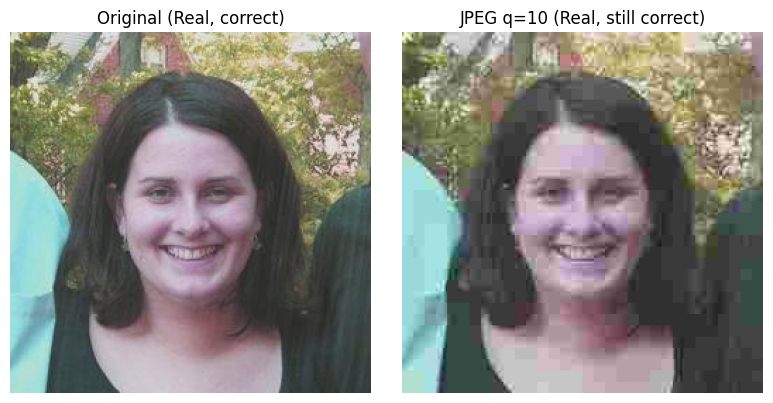

In [38]:
import io
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import torchvision.transforms.functional as F

# ------------------------------------------------------------------
# Config / normalization (adjust if you used different stats)
# ------------------------------------------------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

REAL_LABEL = 1  # class_to_idx['Real']
JPEG_QUALITY = 10

# ------------------------------------------------------------------
# Helpers: normalized <-> [0, 1] image space
# ------------------------------------------------------------------
def denorm_to_01(img: torch.Tensor) -> torch.Tensor:
    """
    img: [..., C, H, W] tensor in normalized space.
    Returns same shape tensor in [0, 1].
    """
    if img.dim() == 3:  # C,H,W
        img = img.unsqueeze(0)
        squeeze_back = True
    else:
        squeeze_back = False

    mean = torch.tensor(IMAGENET_MEAN, device=img.device).view(1, -1, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=img.device).view(1, -1, 1, 1)
    out = (img * std + mean).clamp(0.0, 1.0)

    if squeeze_back:
        out = out[0]
    return out

def renorm_from_01(img01: torch.Tensor) -> torch.Tensor:
    """
    img01: [..., C, H, W] tensor in [0, 1].
    Returns same shape tensor in normalized space.
    """
    if img01.dim() == 3:  # C,H,W
        img01 = img01.unsqueeze(0)
        squeeze_back = True
    else:
        squeeze_back = False

    mean = torch.tensor(IMAGENET_MEAN, device=img01.device).view(1, -1, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=img01.device).view(1, -1, 1, 1)
    out = (img01 - mean) / std

    if squeeze_back:
        out = out[0]
    return out

# ------------------------------------------------------------------
# 1) Find indices of originally correctly classified Real images
# ------------------------------------------------------------------
all_labels_np = np.asarray(all_labels, dtype=int)
all_preds_np  = np.asarray(all_preds, dtype=int)

correct_real_indices = np.where(
    (all_labels_np == REAL_LABEL) & (all_preds_np == REAL_LABEL)
)[0]

print(f"# initially correctly classified Real images: {len(correct_real_indices)}")

# ------------------------------------------------------------------
# 2) Search for one that stays correct under JPEG q=40
# ------------------------------------------------------------------
example_found = False
orig_img_01 = None
jpeg_img_01 = None
chosen_idx = None

cnn_model.eval()

with torch.no_grad():
    for idx in tqdm(correct_real_indices, desc=f"Searching for JPEG-stable Real @ q={JPEG_QUALITY}"):
        # Get normalized tensor from dataset
        img, label = test_dataset[int(idx)]  # img: [C, H, W] (normalized)
        img_norm = img.unsqueeze(0).to(device)  # [1, C, H, W]

        # Convert to [0, 1] on CPU for PIL
        img_01 = denorm_to_01(img_norm)[0].cpu()  # [C, H, W]

        # To PIL, save/compress as JPEG, then reload
        pil_img = F.to_pil_image(img_01)
        buf = io.BytesIO()
        pil_img.save(buf, format="JPEG", quality=JPEG_QUALITY)
        buf.seek(0)
        pil_jpeg = Image.open(buf).convert("RGB")

        jpeg_tensor_01 = F.to_tensor(pil_jpeg)  # [C, H, W] in [0, 1]
        jpeg_tensor_01 = jpeg_tensor_01.unsqueeze(0).to(device)  # [1, C, H, W]

        # Back to normalized space for the model
        jpeg_norm = renorm_from_01(jpeg_tensor_01)

        # Predict on compressed image
        outputs = cnn_model(jpeg_norm)
        pred = outputs.argmax(dim=1).item()

        if pred == REAL_LABEL:
            # Found one: store both original and compressed (in [0, 1]) for plotting
            example_found = True
            chosen_idx = int(idx)
            orig_img_01 = img_01.clone()                     # [C, H, W], CPU, [0,1]
            jpeg_img_01 = jpeg_tensor_01[0].cpu().clone()    # [C, H, W], CPU, [0,1]
            break

if not example_found:
    print(f"No Real example that stays correctly classified at JPEG quality={JPEG_QUALITY}.")
else:
    print(f"Using test_dataset index {chosen_idx} as example Real image.")

    # ------------------------------------------------------------------
    # 3) Plot original vs JPEG-compressed side by side
    # ------------------------------------------------------------------
    # Convert to H,W,C for matplotlib
    orig_np = orig_img_01.numpy().transpose(1, 2, 0)
    jpeg_np = jpeg_img_01.numpy().transpose(1, 2, 0)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(orig_np)
    axes[0].set_title("Original (Real, correct)")
    axes[0].axis("off")

    axes[1].imshow(jpeg_np)
    axes[1].set_title(f"JPEG q={JPEG_QUALITY} (Real, still correct)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


# correctly classified Fake images: 5037
# correctly classified Real images: 4286


Denoise radius=0.0:   0%|          | 0/9323 [00:00<?, ?it/s]

Denoise radius=0.0 → Fake-accuracy: 0.9992, Real-accuracy: 0.9986


Denoise radius=0.5:   0%|          | 0/9323 [00:00<?, ?it/s]

Denoise radius=0.5 → Fake-accuracy: 0.9563, Real-accuracy: 0.9984


Denoise radius=1.0:   0%|          | 0/9323 [00:00<?, ?it/s]

Denoise radius=1.0 → Fake-accuracy: 0.6629, Real-accuracy: 0.9972


Denoise radius=2.0:   0%|          | 0/9323 [00:00<?, ?it/s]

Denoise radius=2.0 → Fake-accuracy: 0.3990, Real-accuracy: 0.9862


Denoise radius=3.0:   0%|          | 0/9323 [00:00<?, ?it/s]

Denoise radius=3.0 → Fake-accuracy: 0.2394, Real-accuracy: 0.9827


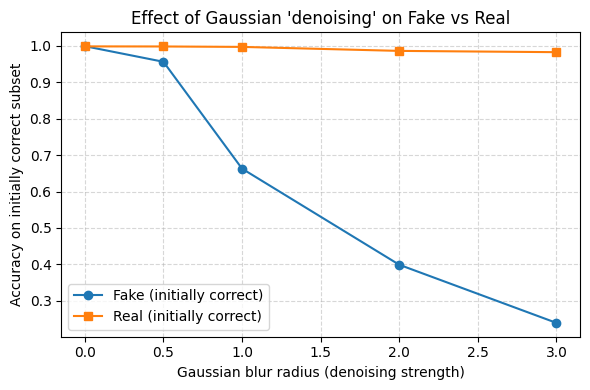

In [34]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import ImageFilter
import torchvision.transforms.functional as F

# ---------------------------------------------------
# Config: denoising "strength" = Gaussian blur radius
#   0.0 = no denoising, higher = stronger smoothing
# ---------------------------------------------------
denoise_radii = [0.0, 0.5, 1.0, 2.0, 3.0]

# Adjust if you used different normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

NEG_LABEL = 0  # Fake
POS_LABEL = 1  # Real

# ---------------------------------------------------
# Helpers: normalized <-> [0, 1] image space
# ---------------------------------------------------
def denorm_to_01(img: torch.Tensor) -> torch.Tensor:
    """
    img: [B, C, H, W] tensor in normalized space.
    Returns [B, C, H, W] tensor roughly in [0, 1].
    """
    mean = torch.tensor(IMAGENET_MEAN, device=img.device).view(1, -1, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=img.device).view(1, -1, 1, 1)
    return (img * std + mean).clamp(0.0, 1.0)

def renorm_from_01(img01: torch.Tensor) -> torch.Tensor:
    """
    img01: [B, C, H, W] tensor in [0, 1].
    Returns [B, C, H, W] tensor in normalized space.
    """
    mean = torch.tensor(IMAGENET_MEAN, device=img01.device).view(1, -1, 1, 1)
    std = torch.tensor(IMAGENET_STD, device=img01.device).view(1, -1, 1, 1)
    return (img01 - mean) / std

# ---------------------------------------------------
# 1) Find correctly classified Fake and Real images
# ---------------------------------------------------
all_labels_np = np.asarray(all_labels, dtype=int)
all_preds_np  = np.asarray(all_preds, dtype=int)

correct_fake_indices = np.where(
    (all_labels_np == NEG_LABEL) & (all_preds_np == NEG_LABEL)
)[0]

correct_real_indices = np.where(
    (all_labels_np == POS_LABEL) & (all_preds_np == POS_LABEL)
)[0]

print(f"# correctly classified Fake images: {len(correct_fake_indices)}")
print(f"# correctly classified Real images: {len(correct_real_indices)}")

if len(correct_fake_indices) == 0 and len(correct_real_indices) == 0:
    print("No correctly classified Fake or Real images found; nothing to test.")
else:
    num_test = len(test_dataset)

    # Boolean masks for quick membership by dataset index
    is_correct_fake = np.zeros(num_test, dtype=bool)
    is_correct_real = np.zeros(num_test, dtype=bool)
    is_correct_fake[correct_fake_indices] = True
    is_correct_real[correct_real_indices] = True

    # Union of both subsets = images we actually evaluate
    subset_indices = np.where(is_correct_fake | is_correct_real)[0]

    total_fake = len(correct_fake_indices)
    total_real = len(correct_real_indices)

    cnn_model.eval()
    accuracies_fake = []
    accuracies_real = []

    # ---------------------------------------------------
    # 2) Sweep over denoising strengths (blur radii)
    # ---------------------------------------------------
    for r in denoise_radii:
        correct_fake = 0
        correct_real = 0

        loop = tqdm(subset_indices,
                    desc=f"Denoise radius={r}",
                    leave=False)

        with torch.no_grad():
            for idx in loop:
                # Get normalized tensor from dataset
                img, label = test_dataset[int(idx)]   # img: [C, H, W]
                img = img.unsqueeze(0).to(device)     # [1, C, H, W]

                # Convert to [0, 1] (for PIL)
                img_01 = denorm_to_01(img)[0].cpu()   # [C, H, W] on CPU
                pil_img = F.to_pil_image(img_01)      # PIL Image

                # Apply "denoising" via Gaussian blur
                if r > 0.0:
                    pil_denoised = pil_img.filter(ImageFilter.GaussianBlur(radius=r))
                else:
                    pil_denoised = pil_img

                # Back to tensor in [0, 1]
                denoised_01 = F.to_tensor(pil_denoised).unsqueeze(0).to(device)  # [1, C, H, W]

                # Back to normalized space for the model
                denoised_norm = renorm_from_01(denoised_01)

                # Predict
                outputs = cnn_model(denoised_norm)
                pred = outputs.argmax(dim=1).item()

                # Update accuracy counters separately
                if is_correct_fake[idx]:
                    if pred == NEG_LABEL:
                        correct_fake += 1

                if is_correct_real[idx]:
                    if pred == POS_LABEL:
                        correct_real += 1

        acc_fake = (correct_fake / total_fake) if total_fake > 0 else float("nan")
        acc_real = (correct_real / total_real) if total_real > 0 else float("nan")

        accuracies_fake.append(acc_fake)
        accuracies_real.append(acc_real)

        print(
            f"Denoise radius={r} → "
            f"Fake-accuracy: {acc_fake:.4f}, "
            f"Real-accuracy: {acc_real:.4f}"
        )

    # ---------------------------------------------------
    # 3) Plot overlay: accuracy vs denoising strength
    # ---------------------------------------------------
    plt.figure(figsize=(6, 4))
    if total_fake > 0:
        plt.plot(denoise_radii, accuracies_fake, marker="o", label="Fake (initially correct)")
    if total_real > 0:
        plt.plot(denoise_radii, accuracies_real, marker="s", label="Real (initially correct)")

    plt.xlabel("Gaussian blur radius (denoising strength)")
    plt.ylabel("Accuracy on initially correct subset")
    plt.title("Effect of Gaussian 'denoising' on Fake vs Real")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


# initially correctly classified Fake images: 5037


Searching Fake misclassification after blur r=1.0:   0%|          | 0/5037 [00:00<?, ?it/s]

Using test_dataset index 12 as example Fake image.
Predicted label after denoising: 1


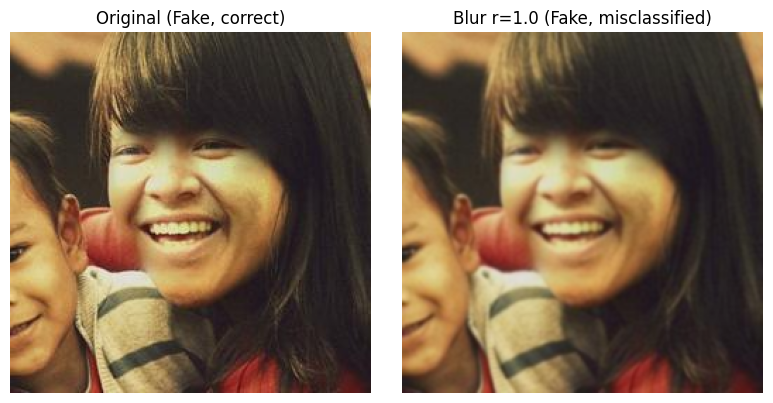

In [42]:
import io
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import ImageFilter
from tqdm.auto import tqdm
import torchvision.transforms.functional as F

# ------------------------------------------------------------------
# Config / normalization (adjust if you used different stats)
# ------------------------------------------------------------------
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

FAKE_LABEL = 0  # class_to_idx['Fake']
DENOISE_RADIUS = 1.0

# ------------------------------------------------------------------
# Helpers: normalized <-> [0, 1] image space
# ------------------------------------------------------------------
def denorm_to_01(img: torch.Tensor) -> torch.Tensor:
    """
    img: [..., C, H, W] tensor in normalized space.
    Returns same shape tensor in [0, 1].
    """
    if img.dim() == 3:  # C,H,W
        img = img.unsqueeze(0)
        squeeze_back = True
    else:
        squeeze_back = False

    mean = torch.tensor(IMAGENET_MEAN, device=img.device).view(1, -1, 1, 1)
    std  = torch.tensor(IMAGENET_STD,  device=img.device).view(1, -1, 1, 1)
    out = (img * std + mean).clamp(0.0, 1.0)

    if squeeze_back:
        out = out[0]
    return out

def renorm_from_01(img01: torch.Tensor) -> torch.Tensor:
    """
    img01: [..., C, H, W] tensor in [0, 1].
    Returns same shape tensor in normalized space.
    """
    if img01.dim() == 3:  # C,H,W
        img01 = img01.unsqueeze(0)
        squeeze_back = True
    else:
        squeeze_back = False

    mean = torch.tensor(IMAGENET_MEAN, device=img01.device).view(1, -1, 1, 1)
    std  = torch.tensor(IMAGENET_STD,  device=img01.device).view(1, -1, 1, 1)
    out = (img01 - mean) / std

    if squeeze_back:
        out = out[0]
    return out

# ------------------------------------------------------------------
# 1) Find indices of originally correctly classified Fake images
# ------------------------------------------------------------------
all_labels_np = np.asarray(all_labels, dtype=int)
all_preds_np  = np.asarray(all_preds, dtype=int)

correct_fake_indices = np.where(
    (all_labels_np == FAKE_LABEL) & (all_preds_np == FAKE_LABEL)
)[0]

print(f"# initially correctly classified Fake images: {len(correct_fake_indices)}")

# ------------------------------------------------------------------
# 2) Search for one that gets misclassified after denoising (radius=2)
# ------------------------------------------------------------------
example_found = False
orig_img_01 = None
denoised_img_01 = None
chosen_idx = None
chosen_pred_after = None

cnn_model.eval()

with torch.no_grad():
    for idx in tqdm(correct_fake_indices, desc=f"Searching Fake misclassification after blur r={DENOISE_RADIUS}"):
        # Get normalized tensor from dataset
        img, label = test_dataset[int(idx)]  # img: [C, H, W] (normalized)
        img_norm = img.unsqueeze(0).to(device)  # [1, C, H, W]

        # Sanity: label should be Fake
        # (not strictly necessary, but good to assert)
        # assert label == FAKE_LABEL

        # Convert to [0, 1] on CPU for PIL
        img_01 = denorm_to_01(img_norm)[0].cpu()  # [C, H, W]

        # To PIL, apply Gaussian blur (our "denoising")
        pil_img = F.to_pil_image(img_01)
        if DENOISE_RADIUS > 0:
            pil_denoised = pil_img.filter(ImageFilter.GaussianBlur(radius=DENOISE_RADIUS))
        else:
            pil_denoised = pil_img

        denoised_tensor_01 = F.to_tensor(pil_denoised)  # [C, H, W] in [0, 1]
        denoised_tensor_01 = denoised_tensor_01.unsqueeze(0).to(device)  # [1, C, H, W]

        # Back to normalized space for the model
        denoised_norm = renorm_from_01(denoised_tensor_01)

        # Predict on denoised image
        outputs = cnn_model(denoised_norm)
        pred = outputs.argmax(dim=1).item()

        if pred != FAKE_LABEL:
            # Found one: store both original and denoised (in [0, 1]) for plotting
            example_found = True
            chosen_idx = int(idx)
            chosen_pred_after = pred
            orig_img_01 = img_01.clone()                          # [C, H, W], CPU, [0,1]
            denoised_img_01 = denoised_tensor_01[0].cpu().clone() # [C, H, W], CPU, [0,1]
            break

if not example_found:
    print(f"No Fake example that becomes misclassified after blur radius={DENOISE_RADIUS}.")
else:
    print(f"Using test_dataset index {chosen_idx} as example Fake image.")
    print(f"Predicted label after denoising: {chosen_pred_after}")

    # ------------------------------------------------------------------
    # 3) Plot original vs denoised side by side
    # ------------------------------------------------------------------
    # Convert to H,W,C for matplotlib
    orig_np     = orig_img_01.numpy().transpose(1, 2, 0)
    denoised_np = denoised_img_01.numpy().transpose(1, 2, 0)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(orig_np)
    axes[0].set_title("Original (Fake, correct)")
    axes[0].axis("off")

    axes[1].imshow(denoised_np)
    axes[1].set_title(f"Blur r={DENOISE_RADIUS} (Fake, misclassified)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()
